## Image Classification

## Setup and dependencies
 

In [458]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import timeit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scikeras.wrappers import KerasClassifier
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

pd.set_option('display.max_rows',28*28)
pd.set_option('display.max_columns',28*28)


## Data loading, preprocessing, and exploration
(https://keras.io/api/datasets/fashion_mnist/).

In [469]:
# Load the Fashion-MNIST dataset training and test sets as numpy arrays

#renamed X_train_full and y_train_full for consistency
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
assert X_train_full.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train_full.shape == (60000,)
assert y_test.shape == (10000,)


In [470]:
# An ordered list of the class names
class_names = ["T-shirt/top",
               "Trouser",
               "Pullover",
               "Dress",
               "Coat",
               "Sandal",
               "Shirt",
               "Sneaker",
               "Bag",
               "Ankle boot"
              ]

### Data Exploration

In [471]:
print("Number of samples in training data:", X_train_full.shape[0])
print('Classes in training data:',np.unique(y_train_full))
print("Dimensions of training data:",(X_train_full.shape[1],X_train_full.shape[2]))
print("Max and min pixel values:", (X_train_full.max(), X_train_full.min()))


Number of samples in training data: 60000
Classes in training data: [0 1 2 3 4 5 6 7 8 9]
Dimensions of training data: (28, 28)
Max and min pixel values: (255, 0)


In [472]:
print('Classes' ,np.unique(y_train_full, return_counts=True)[0])
print('Class distribution' ,np.unique(y_train_full, return_counts=True)[1])


Classes [0 1 2 3 4 5 6 7 8 9]
Class distribution [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


In [473]:
print("Number of samples in test data:", X_test.shape[0])
print('Classes in test data:',np.unique(y_test))
print("Dimensions of test data:",(X_test.shape[1],X_test.shape[2]))
print("Max and min pixel values:", (X_test.max(), X_test.min()))


Number of samples in test data: 10000
Classes in test data: [0 1 2 3 4 5 6 7 8 9]
Dimensions of test data: (28, 28)
Max and min pixel values: (255, 0)


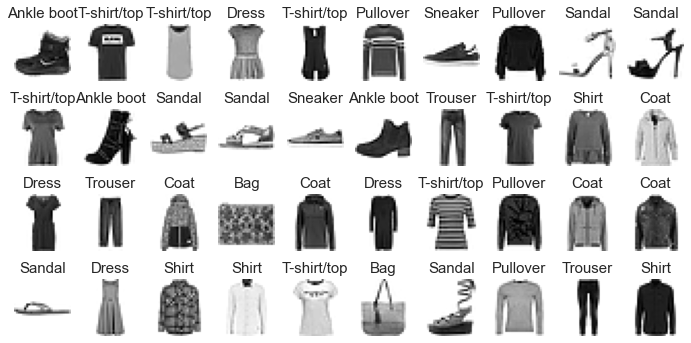

In [479]:
#ploting samples 
class_dic = dict(zip(np.unique(y_train_full), class_names))

def plot_examples(data = X_train_full, labels = y_train_full, n_rows=4, n_cols=10):


    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.5))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.title(class_dic[labels[index]], fontsize = 15)
            plt.axis('off')
            
    plt.show()

plot_examples(X_train_full)


#### Visualising the first ten items in each class

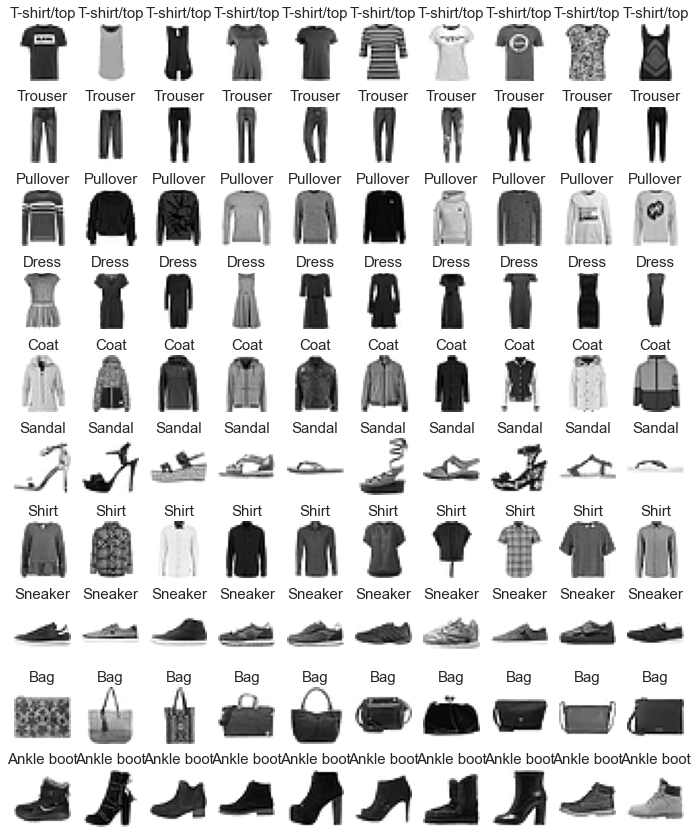

In [481]:
plt.figure(figsize = (12,15))
for j in range(10):
    index = np.where(y_train_full == j)
    for i in range(10):
        plt.subplot(10,10,i+1+10*j)
        plt.imshow(X_train_full[index[0][i]],cmap = 'binary')
        plt.title(class_dic[j],fontsize = 15)
        plt.axis('off')

# From the visualisation, classes 'pullover','coat' and 'shirt' are very similar.

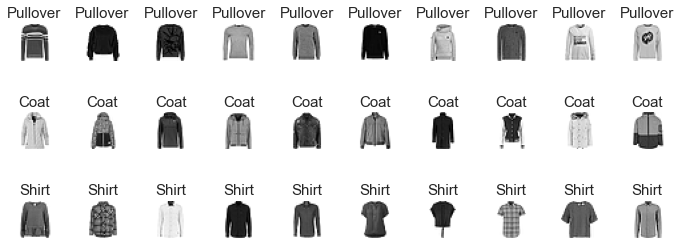

In [482]:
#Plotting pullover, coat and shirt together
plt.figure(figsize = (12,8))
for j in [2,4,6]:
    index = np.where(y_train_full == j)
    for i in range(10):
        plt.subplot(10,10,i+1+10*j)
        plt.imshow(X_train_full[index[0][i]],cmap = 'binary')
        plt.title(class_dic[j], fontsize = 15)
        plt.axis('off')
plt.savefig('similarclasses.jpg')

#### PCA 

In [483]:
X_train_full_reshaped = X_train_full.reshape(60000,28*28)

In [484]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_full_reshaped)
print("Variance explained by first two PCs:", sum(pca.explained_variance_ratio_))

Variance explained by first two PCs: 0.4679453789952785


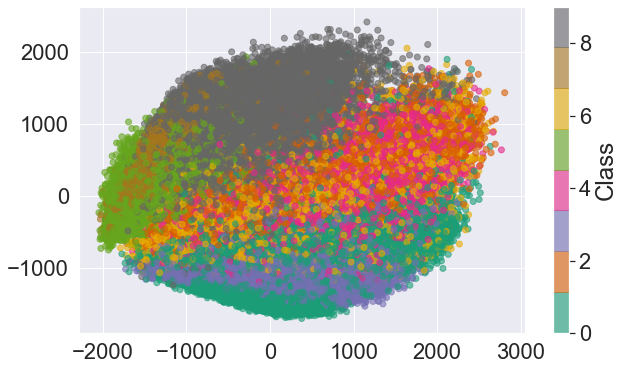

In [485]:
pca_df = pd.DataFrame({'PC1':X_pca[:,0],'PC2':X_pca[:,1],'Class':y_train_full})

plt.figure(figsize = (10,6))
plt.scatter(pca_df['PC1'],pca_df['PC2'], c = pca_df['Class'], cmap = 'Dark2', alpha = 0.6)
plt.colorbar(label = 'Class')
plt.savefig('pca.jpg')

#### Pixel intensity

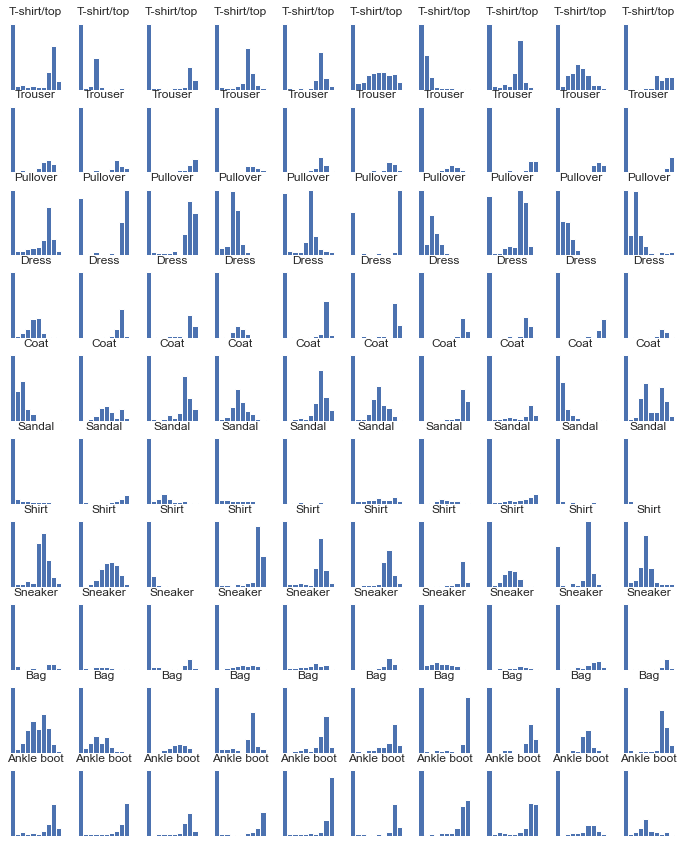

In [486]:
#plotting the pixel intensities of the first ten items from each of the ten classes
plt.figure(figsize = (12,15))
for j in range(10):
    index = np.where(y_train_full == j)
    for i in range(10):
        plt.subplot(10,10,i+1+10*j)
        plt.hist(X_train_full_reshaped[index[0][i]])
        plt.title(class_dic[j], fontsize = 12)
        plt.axis('off')
        
#From the histograms below, pixel indensities vary from image to image both within class and across class.

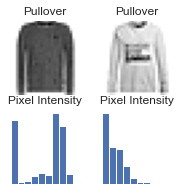

In [487]:
#Plotting example samples from the same class but have different pixel intensities
plt.figure(figsize = (3,3))
plt.subplot(2,2,1)
plt.imshow(X_train_full[np.where(y_train_full == 2)[0][7]],cmap = 'binary')
plt.title(class_dic[2],fontsize = 12)
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(X_train_full[np.where(y_train_full == 2)[0][8]],cmap = 'binary')
plt.title(class_dic[2],fontsize = 12)
plt.axis('off')

plt.subplot(2,2,3)
plt.hist(X_train_full_reshaped[np.where(y_train_full == 2)[0][7]])
plt.axis('off')
plt.title('Pixel Intensity',fontsize = 12)

plt.subplot(2,2,4)
plt.hist(X_train_full_reshaped[np.where(y_train_full == 2)[0][8]])
plt.axis('off')
plt.title('Pixel Intensity',fontsize = 12);

plt.savefig('pixelintensities.jpg')

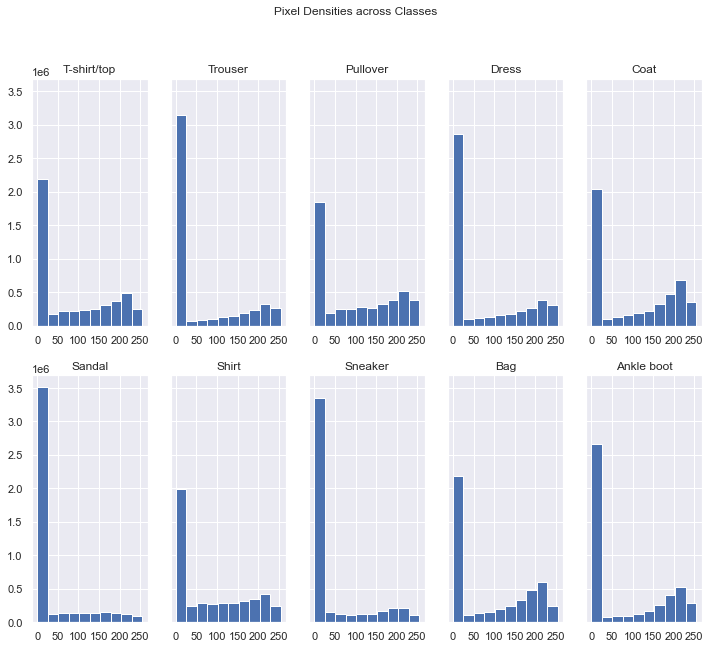

In [494]:
#Plotting the pixel densities of the ten classes
fig, ax = plt.subplots(2, 5, figsize = (12,10), sharey = True)
sns.set_theme(font_scale = 0.5)
for j in range(10):
    index = np.where(y_train_full == j)
    ax[int(j/5),j%5].hist(X_train_full_reshaped[index].flatten())
    ax[int(j/5),j%5].set_title(class_dic[j],fontsize = 12)
plt.suptitle('Pixel Densities across Classes',fontsize = 12)
plt.savefig('acrossclasspixeldensity.jpg')

#### Important features

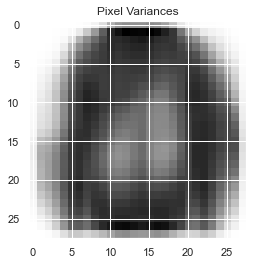

In [496]:
#Method 1

#Calculating the variance of each pixel across the training samples
X_T =  X_train_full_reshaped.transpose()    
var = [np.var(x) for x in X_T]
var = np.array(var).transpose()
var = var.reshape(28,28)

#Plotting the variances on the image. The darker the color, the higher the variance at the pixel.

sns.set_theme(font_scale = 1)
plt.imshow(var, cmap = 'binary')
plt.title('Pixel Variances');
plt.savefig('pixelvariance.jpg')

Number of features that have a correlation (positive and negative) with class higher than 0.5: 105
Number of features that have a correlation (positive and negative) with class lower than 0.1: 195


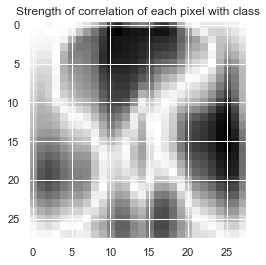

In [497]:
#Method 2 

#creating a correlation matrix of each feature vs class
corr_df = pd.DataFrame(X_train_full_reshaped).join(pd.DataFrame({'class':y_train_full}))
correlations = corr_df.corr()
corr_with_class = correlations['class'].abs().sort_values(ascending = False)
corr_with_class.drop('class',inplace = True)

print('Number of features that have a correlation (positive and negative) with class higher than 0.5:',
     len(corr_with_class[corr_with_class>0.5]))
print('Number of features that have a correlation (positive and negative) with class lower than 0.1:',
     len(corr_with_class[corr_with_class<0.1]))

corr_with_class = pd.DataFrame(corr_with_class)

#projecting correlation strength on image
corr_plotting = corr_with_class.sort_index()
corr_plotting_array = np.array(corr_plotting['class']).reshape(28,28)
plt.imshow(corr_plotting_array, cmap = 'binary')
plt.title('Strength of correlation of each pixel with class')
plt.savefig('correlationstrength.jpg')


### Data Preprocessing

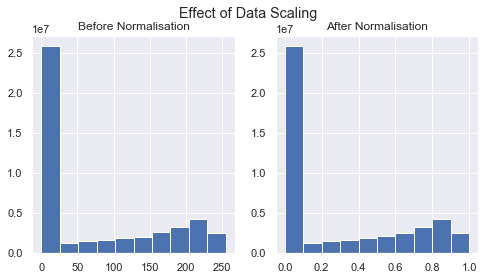

In [498]:
#Comparing pixel densities before and after scaling data to a range of [0,1]
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.hist(X_train_full.flatten())
ax1.set_title('Before Normalisation')

X_train_full = X_train_full/255

ax2.hist(X_train_full.flatten())
ax2.set_title('After Normalisation')

plt.suptitle('Effect of Data Scaling')
plt.savefig('scaling.jpg')

## Algorithm design and setup

In [499]:
#create validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42, test_size = 0.1)


In [500]:
print('Train set dimensions: ',X_train.shape)
print('Validation set dimensions: ',X_valid.shape)


Train set dimensions:  (54000, 28, 28)
Validation set dimensions:  (6000, 28, 28)


### Random forest (algorithm of choice from first six weeks of course)

In [501]:
#reshaping matrix
X_train_rf = X_train.reshape(X_train.shape[0], 28*28)
X_valid_rf = X_valid.reshape(X_valid.shape[0], 28*28)

print('Shape of X_train_rf: ', X_train_rf.shape)
print('Shape of X_valid_rf: ', X_valid_rf.shape)

Shape of X_train_rf:  (54000, 784)
Shape of X_valid_rf:  (6000, 784)


In [502]:

#Creating random forest classifier with default parameters

start = timeit.default_timer()

rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_rf, y_train)

print(rf.score(X_valid_rf,y_valid))
stop = timeit.default_timer()

print('Random forest runtime in seconds: ', stop - start) 


0.8823333333333333
Random forest runtime in seconds:  66.53727622202132


In [503]:
print('Depth of trees: ',[estimator.tree_.max_depth for estimator in rf.estimators_])

Depth of trees:  [48, 34, 34, 32, 34, 35, 35, 36, 40, 39, 31, 36, 34, 34, 35, 35, 39, 34, 40, 33, 37, 40, 37, 35, 37, 42, 35, 34, 37, 44, 37, 44, 38, 35, 36, 39, 37, 41, 34, 42, 34, 35, 34, 33, 43, 36, 36, 39, 37, 35, 36, 35, 32, 35, 36, 48, 35, 38, 36, 37, 37, 37, 33, 35, 31, 39, 38, 43, 32, 34, 36, 34, 45, 36, 33, 37, 36, 40, 35, 34, 34, 35, 35, 35, 34, 36, 36, 32, 39, 40, 45, 38, 34, 36, 35, 38, 41, 36, 36, 37]


### Fully connected neural network

In [504]:
X_train_mlp = X_train.copy()
X_valid_mlp = X_valid.copy()

print('Shape of X_train: ', X_train_mlp.shape)
print('Shape of X_valid: ', X_valid_mlp.shape)

Shape of X_train:  (54000, 28, 28)
Shape of X_valid:  (6000, 28, 28)


In [505]:
#initialising mlp model
keras.backend.clear_session()
tf.random.set_seed(42)

model_mlp = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="tanh"),
    keras.layers.Dense(100, activation="tanh"),
    keras.layers.Dense(10, activation="softmax")
])


In [506]:
model_mlp.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [507]:
#setting up optimiser and compiling model
opt_mlp = keras.optimizers.SGD(learning_rate=1e-2)
model_mlp.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt_mlp,
              metrics=['accuracy'])


In [508]:
# running mlp base model
start = timeit.default_timer()

history_mlp = model_mlp.fit(X_train_mlp, y_train, epochs=30,
                    validation_data=(X_valid_mlp, y_valid))

stop = timeit.default_timer()
print('MLP runtime in seconds: ', stop - start) 


Epoch 1/30
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6724 - accuracy: 0.7780 - val_loss: 0.5166 - val_accuracy: 0.8200
Epoch 2/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4715 - accuracy: 0.8352 - val_loss: 0.4788 - val_accuracy: 0.8290
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4324 - accuracy: 0.8469 - val_loss: 0.4305 - val_accuracy: 0.8443
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4092 - accuracy: 0.8550 - val_loss: 0.4071 - val_accuracy: 0.8530
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3938 - accuracy: 0.8595 - val_loss: 0.4043 - val_accuracy: 0.8550
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3807 - accuracy: 0.8640 - val_loss: 0.4106 - val_accuracy: 0.8492
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3705 - accuracy: 0.8684 - val_loss: 0.3825 - val_accuracy:

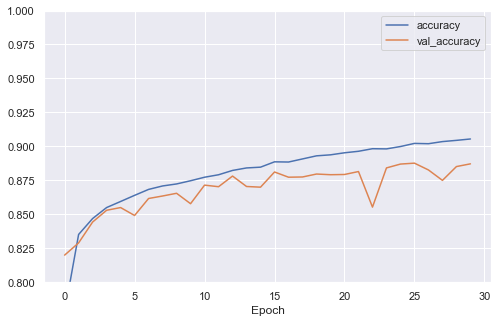

In [509]:
accuracies = pd.DataFrame(history_mlp.history)[['accuracy', 'val_accuracy']]

# plotting the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

### Convolutional neural network

In [510]:
#transforming shape of data for CNN
X_train_cnn = np.expand_dims(X_train, -1)
X_valid_cnn = np.expand_dims(X_valid, -1)

print('shape of X_train_cnn: ',X_train_cnn.shape)
print('shape of X_valid_cnn: ',X_valid_cnn.shape)

shape of X_train_cnn:  (54000, 28, 28, 1)
shape of X_valid_cnn:  (6000, 28, 28, 1)


In [511]:
tf.random.set_seed(42)
keras.backend.clear_session()


In [512]:
#creating CNN model
model_cnn = keras.Sequential([
    
    keras.Input(shape=(28, 28, 1)),
    
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
])

In [513]:

model_cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [514]:
# compiling CNN model
model_cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])


In [515]:
# running base CNN model
batch_size = 128
epochs = 15

start = timeit.default_timer()

history_cnn = model_cnn.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

stop = timeit.default_timer()
print('MLP runtime in seconds: ', stop - start) 


Epoch 1/15
422/422 [==============================] - 16s 36ms/step - loss: 0.6970 - accuracy: 0.7480 - val_loss: 0.4440 - val_accuracy: 0.8412
Epoch 2/15
422/422 [==============================] - 15s 35ms/step - loss: 0.4564 - accuracy: 0.8347 - val_loss: 0.3859 - val_accuracy: 0.8562
Epoch 3/15
422/422 [==============================] - 16s 37ms/step - loss: 0.4052 - accuracy: 0.8534 - val_loss: 0.3548 - val_accuracy: 0.8755
Epoch 4/15
422/422 [==============================] - 16s 38ms/step - loss: 0.3741 - accuracy: 0.8654 - val_loss: 0.3246 - val_accuracy: 0.8857
Epoch 5/15
422/422 [==============================] - 16s 39ms/step - loss: 0.3548 - accuracy: 0.8717 - val_loss: 0.3126 - val_accuracy: 0.8878
Epoch 6/15
422/422 [==============================] - 17s 39ms/step - loss: 0.3330 - accuracy: 0.8808 - val_loss: 0.2911 - val_accuracy: 0.8985
Epoch 7/15
422/422 [==============================] - 16s 37ms/step - loss: 0.3219 - accuracy: 0.8829 - val_loss: 0.2836 - val_accuracy:

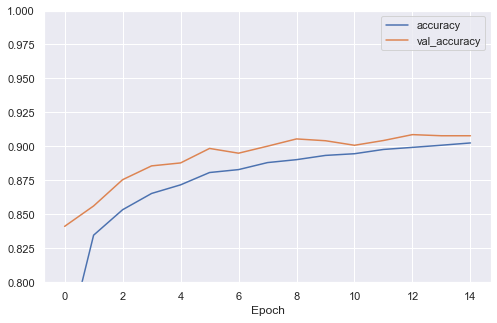

In [516]:
accuracies = pd.DataFrame(history_cnn.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

## Hyperparameter tuning

### Random forest (algorithm of choice from first six weeks of course)

In [148]:
cvKFold=StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [135]:

#Using full training data for cross validation
X_train_rf_gridsearch = X_train_full.reshape(60000, 28*28)
print('Dimensions of X_train_rf_gridsearch: ',X_train_rf_gridsearch.shape)

Dimensions of X_train_rf_gridsearch:  (60000, 784)


In [158]:
#Grid search with random forest



start = timeit.default_timer()

criterion = ['entropy','gini','log_loss']
max_depth = [40, 50]
n_estimators = [50, 100, 150]

rf_param = {'criterion':criterion, 'max_depth':max_depth, 'n_estimators':n_estimators}

rf_search = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid=rf_param, cv = cvKFold)
rf_search.fit(X_train_rf_gridsearch, y_train_full)

stop = timeit.default_timer()
print('Random forest grid search runtime in seconds: ', stop - start) 
print(rf_search.best_params_)
print(rf_search.best_score_)


Random forest grid search runtime in seconds:  2825.65235612799
{'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 150}
0.88285


In [160]:
# putting parameter tuning results into a dataframe for easy comparison

rf_search_df = pd.DataFrame({'parameters':rf_search.cv_results_['params'],
                            'fit_time':rf_search.cv_results_['mean_fit_time'],
                            'mean_test_score':rf_search.cv_results_['mean_test_score']})

for para in rf_param.keys():
    rf_search_df[para] = rf_search_df['parameters'].apply(lambda x: x[para])
    
rf_search_df.drop('parameters', axis = 1, inplace = True)


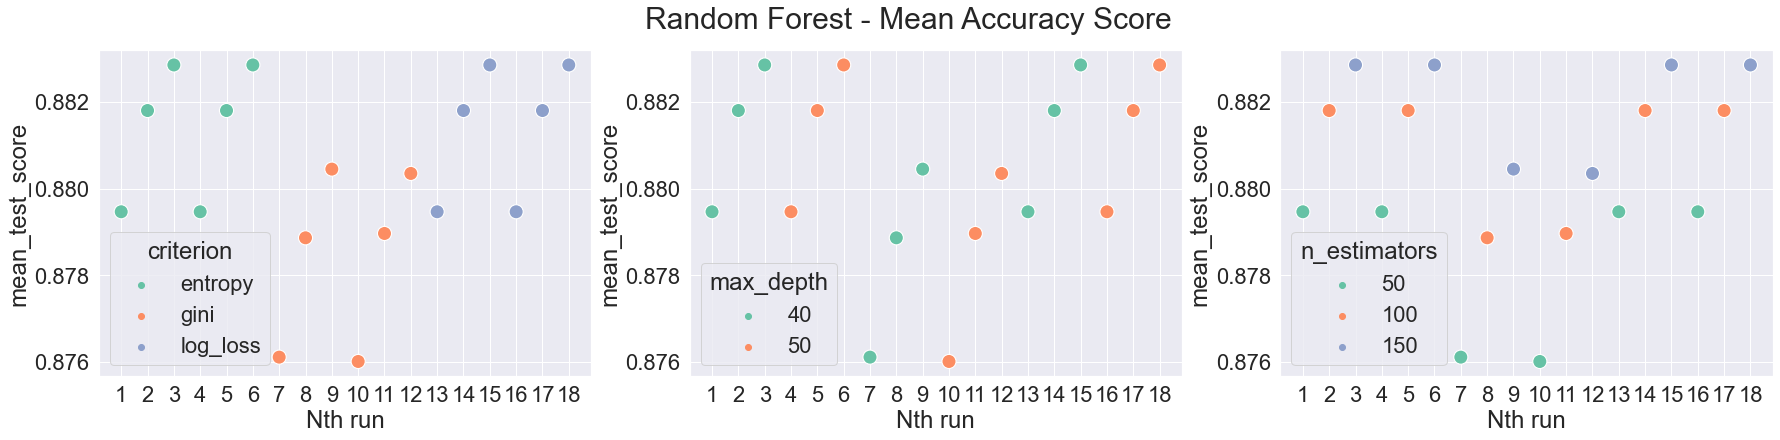

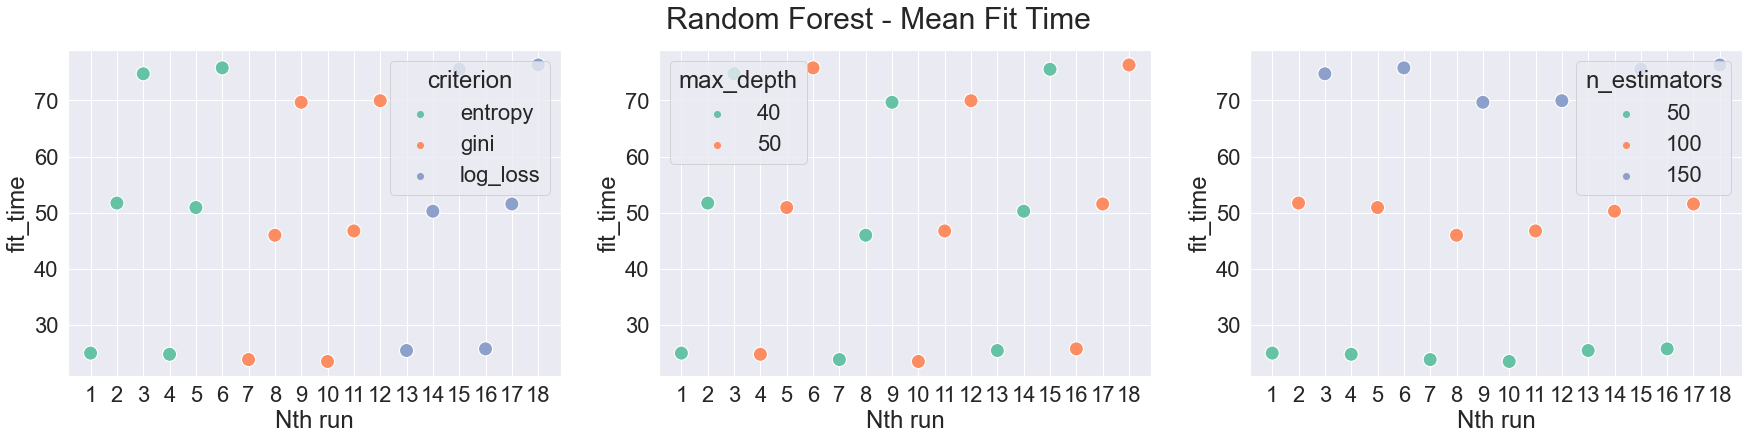

In [225]:
fig, ax = plt.subplots(1, 3, figsize = (30,6))
for i in range(len(rf_param.keys())):
    sns.set(font_scale=2)
    sns.scatterplot(x = rf_search_df.index+1, y = rf_search_df['mean_test_score'], 
                    hue = rf_search_df[list(rf_param.keys())[i]], 
                    s = 200,
                    palette = 'Set2', ax = ax[i])
    ax[i].set(xlabel = 'Nth run')
    ax[i].set_xticks(rf_search_df.index+1)
plt.suptitle('Random Forest - Mean Accuracy Score',fontsize = 30)
plt.savefig('rfaccuracy.jpg')
    
fig, ax = plt.subplots(1, 3, figsize = (30,6))    
for i in range(len(rf_param.keys())):
    sns.set(font_scale=2)
    sns.scatterplot(x = rf_search_df.index+1, y = rf_search_df['fit_time'], 
                    hue = rf_search_df[list(rf_param.keys())[i]], 
                    s = 200,
                    palette = 'Set2', ax = ax[i])
    ax[i].set(xlabel = 'Nth run')
    ax[i].set_xticks(rf_search_df.index+1)
plt.suptitle('Random Forest - Mean Fit Time', fontsize = 30)
plt.savefig('rfruntime.jpg')

In [427]:
print('Mean result by max depth:')
rf_search_df.groupby(by = 'max_depth').mean()[['fit_time','mean_test_score']]

Mean result by max depth:


,fit_time,mean_test_score
max_depth,,
40,49.1321,0.8804
50,49.4771,0.8804


In [428]:
print('Mean result by criterion:')
rf_search_df.groupby(by = 'criterion').mean()[['fit_time','mean_test_score']]

Mean result by criterion:


,fit_time,mean_test_score
criterion,,
entropy,50.4905,0.8814
gini,46.6117,0.8785
log_loss,50.8116,0.8814


In [429]:
print('Mean result by number of estimators:')
rf_search_df.groupby(by = 'n_estimators').mean()[['fit_time','mean_test_score']]

Mean result by number of estimators:


,fit_time,mean_test_score
n_estimators,,
50,24.7079,0.8783
100,49.5291,0.8808
150,73.6769,0.8820


In [519]:
rf_final_params = rf_search.best_params_

print('Best random forest model parameters:', rf_final_params)

Best random forest model parameters: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 150}


### Fully connected neural network

In [165]:
# Using full training set for cross validation
X_train_mlp_gridsearch = X_train_full.copy()


In [207]:
tf.random.set_seed(42)
keras.backend.clear_session()


In [208]:
def build_mlp(n_hidden_neurons=100,
    activation_function="relu", input_shape=[28,28]
):
    
    model = keras.models.Sequential()
    
    model.add(keras.layers.Flatten(input_shape=input_shape))
    
    for layer in range(2):
        model.add(keras.layers.Dense(n_hidden_neurons, activation=activation_function))
        
    model.add(keras.layers.Dense(10, activation="softmax"))
    
    return model

In [209]:
build_mlp().summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [210]:
keras_classifier = KerasClassifier(build_mlp,
                                   n_hidden_neurons=100,
                                   activation_function="relu",
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   optimizer__lr=0.01,
                                   metrics=["accuracy"]
                                  )

In [212]:
param_grid_mlp = {
    "n_hidden_neurons":[50,100],
    "optimizer__lr": [0.1, 0.01, 0.001],
    "activation_function": ["relu", "sigmoid", "tanh", "linear"]
}

start = timeit.default_timer()

grid_search_mlp_cv = GridSearchCV(keras_classifier, param_grid_mlp, cv=cvKFold, verbose=2)
history_mlp_cv = grid_search_mlp_cv.fit(X_train_mlp_gridsearch, y_train_full, 
                                        batch_size = 128, epochs=20)

stop = timeit.default_timer()
print('MLP grid search runtime in seconds: ', stop - start) 
print(history_mlp_cv.best_params_)
print(history_mlp_cv.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 0.7670 - accuracy: 0.7286
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5110 - accuracy: 0.8181
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4593 - accuracy: 0.8350
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4256 - accuracy: 0.8484
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3990 - accuracy: 0.8572
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3820 - accuracy: 0.8631
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3692 - accuracy: 0.8669
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3543 - accuracy: 0.8709
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3457 - accuracy: 0.8748
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3359 - accuracy: 0.8780

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 0.7691 - accuracy: 0.7228
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5107 - accuracy: 0.8174
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4557 - accuracy: 0.8357
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4209 - accuracy: 0.8486
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4005 - accuracy: 0.8542
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3839 - accuracy: 0.8601
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3701 - accuracy: 0.8645
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3585 - accuracy: 0.8696
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3476 - accuracy: 0.8732
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3437 - accuracy: 0.8730

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 0.7653 - accuracy: 0.7312
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5005 - accuracy: 0.8208
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4495 - accuracy: 0.8372
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4128 - accuracy: 0.8494
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3914 - accuracy: 0.8571
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3751 - accuracy: 0.8620
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3571 - accuracy: 0.8698
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3488 - accuracy: 0.8719
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3396 - accuracy: 0.8750
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3317 - accuracy: 0.8768

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.4184 - accuracy: 0.5577
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8176 - accuracy: 0.7194
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6887 - accuracy: 0.7644
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6208 - accuracy: 0.7894
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5775 - accuracy: 0.8034
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5482 - accuracy: 0.8132
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5268 - accuracy: 0.8180
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5092 - accuracy: 0.8231
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4949 - accuracy: 0.8276
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4840 - accuracy: 0.8306

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.3247 - accuracy: 0.5911
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7892 - accuracy: 0.7330
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6653 - accuracy: 0.7780
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5980 - accuracy: 0.7991
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5590 - accuracy: 0.8104
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5330 - accuracy: 0.8175
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5127 - accuracy: 0.8252
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4979 - accuracy: 0.8286
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4860 - accuracy: 0.8327
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4771 - accuracy: 0.8340

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.3815 - accuracy: 0.5766
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7650 - accuracy: 0.7494
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6433 - accuracy: 0.7852
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5850 - accuracy: 0.8018
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5495 - accuracy: 0.8135
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5247 - accuracy: 0.8193
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5052 - accuracy: 0.8256
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4913 - accuracy: 0.8308
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4801 - accuracy: 0.8344
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4708 - accuracy: 0.8359

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.2314 - accuracy: 0.2296
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 2.0085 - accuracy: 0.3787
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.8160 - accuracy: 0.4592
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 1.6251 - accuracy: 0.5508
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.4453 - accuracy: 0.6050
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.2959 - accuracy: 0.6331
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1806 - accuracy: 0.6474
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0914 - accuracy: 0.6599
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0225 - accuracy: 0.6708
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9684 - accuracy: 0.6813

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.1444 - accuracy: 0.2263
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.8034 - accuracy: 0.3735
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.5535 - accuracy: 0.5344
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 1.3518 - accuracy: 0.6333
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1991 - accuracy: 0.6655
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0873 - accuracy: 0.6823
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0057 - accuracy: 0.6960
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9447 - accuracy: 0.7060
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8973 - accuracy: 0.7155
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8593 - accuracy: 0.7228

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.2166 - accuracy: 0.1604
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.9863 - accuracy: 0.3110
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.7834 - accuracy: 0.4869
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 1.5847 - accuracy: 0.5707
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.4118 - accuracy: 0.6124
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.2737 - accuracy: 0.6375
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1668 - accuracy: 0.6541
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0838 - accuracy: 0.6658
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0188 - accuracy: 0.6779
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9666 - accuracy: 0.6874

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 0.7592 - accuracy: 0.7363
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4974 - accuracy: 0.8205
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4465 - accuracy: 0.8390
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4098 - accuracy: 0.8526
Epoch 5/20
313/313 [==============================] - 1s 2ms/step - loss: 0.3833 - accuracy: 0.8616
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3664 - accuracy: 0.8674
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3525 - accuracy: 0.8720
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3396 - accuracy: 0.8744
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3296 - accuracy: 0.8789
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3192 - accuracy: 0.8833

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 0.7307 - accuracy: 0.7455
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4987 - accuracy: 0.8220
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4429 - accuracy: 0.8405
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4057 - accuracy: 0.8528
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3862 - accuracy: 0.8583
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3677 - accuracy: 0.8656
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3533 - accuracy: 0.8699
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3399 - accuracy: 0.8766
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3286 - accuracy: 0.8790
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3224 - accuracy: 0.8800

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 0.7244 - accuracy: 0.7449
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4917 - accuracy: 0.8249
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4435 - accuracy: 0.8399
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4095 - accuracy: 0.8507
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3879 - accuracy: 0.8576
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3696 - accuracy: 0.8654
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3505 - accuracy: 0.8735
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3418 - accuracy: 0.8740
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3302 - accuracy: 0.8791
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3239 - accuracy: 0.8795

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 1.3064 - accuracy: 0.6097
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7509 - accuracy: 0.7466
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6400 - accuracy: 0.7838
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5817 - accuracy: 0.8047
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5449 - accuracy: 0.8152
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5194 - accuracy: 0.8249
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5014 - accuracy: 0.8289
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4865 - accuracy: 0.8331
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4739 - accuracy: 0.8363
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4646 - accuracy: 0.8396

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 1.3440 - accuracy: 0.5888
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7756 - accuracy: 0.7394
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6584 - accuracy: 0.7815
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5948 - accuracy: 0.8023
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5546 - accuracy: 0.8128
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5271 - accuracy: 0.8205
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5057 - accuracy: 0.8277
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4902 - accuracy: 0.8310
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4783 - accuracy: 0.8339
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4696 - accuracy: 0.8368

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.2646 - accuracy: 0.6180
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7387 - accuracy: 0.7524
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6311 - accuracy: 0.7880
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5755 - accuracy: 0.8063
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5408 - accuracy: 0.8162
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5166 - accuracy: 0.8230
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4974 - accuracy: 0.8296
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4840 - accuracy: 0.8340
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4725 - accuracy: 0.8371
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4625 - accuracy: 0.8388

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.1900 - accuracy: 0.1903
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.9180 - accuracy: 0.4288
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.6724 - accuracy: 0.5286
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 1.4585 - accuracy: 0.5984
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.2940 - accuracy: 0.6349
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1721 - accuracy: 0.6561
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0807 - accuracy: 0.6691
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0109 - accuracy: 0.6827
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9565 - accuracy: 0.6931
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9125 - accuracy: 0.7035

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.1201 - accuracy: 0.2747
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.8170 - accuracy: 0.4777
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.5568 - accuracy: 0.5735
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 1.3546 - accuracy: 0.6148
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.2095 - accuracy: 0.6350
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1048 - accuracy: 0.6501
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0273 - accuracy: 0.6642
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9684 - accuracy: 0.6766
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9224 - accuracy: 0.6875
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8851 - accuracy: 0.6971

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 2.1321 - accuracy: 0.3264
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.8308 - accuracy: 0.5357
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.5563 - accuracy: 0.6184
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 1.3433 - accuracy: 0.6470
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1951 - accuracy: 0.6601
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0908 - accuracy: 0.6697
Epoch 7/20
313/313 [==============================] - 1s 2ms/step - loss: 1.0150 - accuracy: 0.6805
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9584 - accuracy: 0.6874
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9145 - accuracy: 0.6957
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8792 - accuracy: 0.7027

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.8891 - accuracy: 0.4535
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1348 - accuracy: 0.6385
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8734 - accuracy: 0.7080
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7429 - accuracy: 0.7416
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6650 - accuracy: 0.7618
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6128 - accuracy: 0.7765
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5756 - accuracy: 0.7883
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5466 - accuracy: 0.8009
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5239 - accuracy: 0.8118
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5051 - accuracy: 0.8193

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.8916 - accuracy: 0.4509
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1251 - accuracy: 0.6348
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8697 - accuracy: 0.6933
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7501 - accuracy: 0.7348
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6714 - accuracy: 0.7609
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6158 - accuracy: 0.7806
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5749 - accuracy: 0.7978
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5443 - accuracy: 0.8093
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5201 - accuracy: 0.8174
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5008 - accuracy: 0.8238

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.9084 - accuracy: 0.4397
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1631 - accuracy: 0.6337
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8935 - accuracy: 0.7034
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7549 - accuracy: 0.7437
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6709 - accuracy: 0.7637
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6169 - accuracy: 0.7784
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5781 - accuracy: 0.7902
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5494 - accuracy: 0.8017
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5269 - accuracy: 0.8123
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5080 - accuracy: 0.8191

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.3061 - accuracy: 0.1831
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2298 - accuracy: 0.3334
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 2.1650 - accuracy: 0.3936
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 2.0772 - accuracy: 0.4266
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.9669 - accuracy: 0.4652
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.8470 - accuracy: 0.4931
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 1.7348 - accuracy: 0.5289
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 1.6369 - accuracy: 0.5380
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 1.5515 - accuracy: 0.5586
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 1.4752 - accuracy: 0.5684

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.3050 - accuracy: 0.2297
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2284 - accuracy: 0.4224
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 2.1696 - accuracy: 0.4885
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 2.0892 - accuracy: 0.5336
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.9827 - accuracy: 0.5382
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.8606 - accuracy: 0.5368
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 1.7411 - accuracy: 0.5450
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 1.6347 - accuracy: 0.5546
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 1.5425 - accuracy: 0.5624
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 1.4621 - accuracy: 0.5769

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.3196 - accuracy: 0.1688
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2265 - accuracy: 0.4186
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 2.1568 - accuracy: 0.4869
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 2.0651 - accuracy: 0.4967
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.9502 - accuracy: 0.5071
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.8264 - accuracy: 0.5229
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 1.7102 - accuracy: 0.5314
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 1.6074 - accuracy: 0.5381
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 1.5159 - accuracy: 0.5630
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 1.4332 - accuracy: 0.5662

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.3976 - accuracy: 0.1000
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 2.3375 - accuracy: 0.1000
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 2.3127 - accuracy: 0.0999
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 2.3006 - accuracy: 0.0987
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2934 - accuracy: 0.1075
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2882 - accuracy: 0.1271
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2836 - accuracy: 0.1640
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2794 - accuracy: 0.2074
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2751 - accuracy: 0.2954
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2709 - accuracy: 0.3295

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.4440 - accuracy: 0.1000
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 2.3530 - accuracy: 0.1000
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 2.3172 - accuracy: 0.1070
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 2.3002 - accuracy: 0.1570
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2908 - accuracy: 0.2181
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2846 - accuracy: 0.2651
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2796 - accuracy: 0.2932
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2751 - accuracy: 0.3003
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2708 - accuracy: 0.3106
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2666 - accuracy: 0.3195

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.3755 - accuracy: 0.0799
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 2.3263 - accuracy: 0.0836
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 2.3047 - accuracy: 0.1024
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2939 - accuracy: 0.1297
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2874 - accuracy: 0.1408
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2825 - accuracy: 0.1741
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2783 - accuracy: 0.2293
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2742 - accuracy: 0.2607
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2702 - accuracy: 0.2821
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2662 - accuracy: 0.3040

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 1.7946 - accuracy: 0.4630
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0359 - accuracy: 0.6740
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7905 - accuracy: 0.7256
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6838 - accuracy: 0.7534
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6231 - accuracy: 0.7742
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5802 - accuracy: 0.7933
Epoch 7/20
313/313 [==============================] - 0s 2ms/step - loss: 0.5476 - accuracy: 0.8078
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5212 - accuracy: 0.8174
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5005 - accuracy: 0.8255
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4843 - accuracy: 0.8296

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 1.8028 - accuracy: 0.4372
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0622 - accuracy: 0.6633
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8167 - accuracy: 0.7204
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.7503
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6336 - accuracy: 0.7687
Epoch 6/20
313/313 [==============================] - 0s 2ms/step - loss: 0.5922 - accuracy: 0.7844
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5604 - accuracy: 0.7969
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5357 - accuracy: 0.8078
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5152 - accuracy: 0.8172
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4988 - accuracy: 0.8229

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 1.8227 - accuracy: 0.4457
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0363 - accuracy: 0.6529
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8018 - accuracy: 0.7261
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6888 - accuracy: 0.7533
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6277 - accuracy: 0.7709
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5869 - accuracy: 0.7869
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5542 - accuracy: 0.8028
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5292 - accuracy: 0.8108
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5091 - accuracy: 0.8202
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4925 - accuracy: 0.8250

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 2.2869 - accuracy: 0.2040
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2306 - accuracy: 0.4597
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 2.1655 - accuracy: 0.5304
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 2.0729 - accuracy: 0.5420
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.9448 - accuracy: 0.5327
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.7916 - accuracy: 0.5457
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 1.6411 - accuracy: 0.5713
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 1.5117 - accuracy: 0.5931
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 1.4051 - accuracy: 0.6219
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 1.3170 - accuracy: 0.6423

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 2.2842 - accuracy: 0.2725
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2038 - accuracy: 0.4424
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 2.1218 - accuracy: 0.4866
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 2.0080 - accuracy: 0.4992
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.8640 - accuracy: 0.5205
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.7152 - accuracy: 0.5388
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 1.5837 - accuracy: 0.5706
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 1.4733 - accuracy: 0.5907
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 1.3801 - accuracy: 0.6172
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 1.3007 - accuracy: 0.6330

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 2.2834 - accuracy: 0.2572
Epoch 2/20
313/313 [==============================] - 1s 2ms/step - loss: 2.2163 - accuracy: 0.4381
Epoch 3/20
313/313 [==============================] - 1s 2ms/step - loss: 2.1444 - accuracy: 0.5417
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 2.0425 - accuracy: 0.5767
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.9036 - accuracy: 0.5834
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.7424 - accuracy: 0.5946
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 1.5873 - accuracy: 0.6089
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 1.4572 - accuracy: 0.6134
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 1.3528 - accuracy: 0.6368
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 1.2689 - accuracy: 0.6350

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 2.3744 - accuracy: 0.1153
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 2.3069 - accuracy: 0.1233
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2883 - accuracy: 0.1850
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2804 - accuracy: 0.2540
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2746 - accuracy: 0.3044
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2691 - accuracy: 0.3602
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2635 - accuracy: 0.3864
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2580 - accuracy: 0.4251
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2523 - accuracy: 0.4205
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2466 - accuracy: 0.4699

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.3626 - accuracy: 0.1115
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 2.3076 - accuracy: 0.1118
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2931 - accuracy: 0.1273
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2856 - accuracy: 0.1812
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2791 - accuracy: 0.2299
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2729 - accuracy: 0.3253
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2666 - accuracy: 0.3411
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2603 - accuracy: 0.4143
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2539 - accuracy: 0.4409
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2475 - accuracy: 0.4573

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 2.3489 - accuracy: 0.0651
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 2.3035 - accuracy: 0.0811
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2921 - accuracy: 0.1485
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2855 - accuracy: 0.2197
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2795 - accuracy: 0.2768
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2736 - accuracy: 0.3070
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2677 - accuracy: 0.3392
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2616 - accuracy: 0.3533
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2555 - accuracy: 0.3941
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 2.2493 - accuracy: 0.3947

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 0.6980 - accuracy: 0.7634
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4800 - accuracy: 0.8268
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4389 - accuracy: 0.8414
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4141 - accuracy: 0.8525
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3928 - accuracy: 0.8590
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3769 - accuracy: 0.8650
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3670 - accuracy: 0.8676
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3534 - accuracy: 0.8720
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3446 - accuracy: 0.8752
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3362 - accuracy: 0.8788

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 0.6956 - accuracy: 0.7606
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4808 - accuracy: 0.8263
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4377 - accuracy: 0.8408
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4067 - accuracy: 0.8537
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3913 - accuracy: 0.8577
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3751 - accuracy: 0.8632
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3616 - accuracy: 0.8666
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3496 - accuracy: 0.8723
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3409 - accuracy: 0.8766
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3369 - accuracy: 0.8766

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 0.6936 - accuracy: 0.7673
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4753 - accuracy: 0.8296
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4328 - accuracy: 0.8431
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4030 - accuracy: 0.8530
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3860 - accuracy: 0.8604
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3705 - accuracy: 0.8643
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3555 - accuracy: 0.8706
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3477 - accuracy: 0.8731
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3393 - accuracy: 0.8775
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3315 - accuracy: 0.8790

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.2823 - accuracy: 0.6247
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8054 - accuracy: 0.7478
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6815 - accuracy: 0.7780
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6156 - accuracy: 0.7966
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5733 - accuracy: 0.8080
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5430 - accuracy: 0.8159
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5206 - accuracy: 0.8222
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5025 - accuracy: 0.8277
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4879 - accuracy: 0.8317
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4758 - accuracy: 0.8353

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.2889 - accuracy: 0.6093
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8087 - accuracy: 0.7389
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6815 - accuracy: 0.7779
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6133 - accuracy: 0.7977
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5694 - accuracy: 0.8101
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5389 - accuracy: 0.8177
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5159 - accuracy: 0.8239
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4988 - accuracy: 0.8285
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4848 - accuracy: 0.8326
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4735 - accuracy: 0.8353

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.3126 - accuracy: 0.6229
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8142 - accuracy: 0.7435
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6846 - accuracy: 0.7810
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6164 - accuracy: 0.7978
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5731 - accuracy: 0.8094
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5430 - accuracy: 0.8153
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5201 - accuracy: 0.8219
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5026 - accuracy: 0.8253
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4884 - accuracy: 0.8300
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4765 - accuracy: 0.8329

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.0966 - accuracy: 0.2893
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.6889 - accuracy: 0.5289
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.4347 - accuracy: 0.6141
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 1.2668 - accuracy: 0.6554
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1526 - accuracy: 0.6742
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0708 - accuracy: 0.6858
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0091 - accuracy: 0.6953
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9605 - accuracy: 0.7034
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9211 - accuracy: 0.7117
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8881 - accuracy: 0.7180

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.0052 - accuracy: 0.3536
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.6273 - accuracy: 0.5436
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.4217 - accuracy: 0.6007
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 1.2903 - accuracy: 0.6279
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1976 - accuracy: 0.6474
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1272 - accuracy: 0.6615
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0709 - accuracy: 0.6751
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0243 - accuracy: 0.6860
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9848 - accuracy: 0.6956
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9505 - accuracy: 0.7035

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.0569 - accuracy: 0.3275
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.6734 - accuracy: 0.5847
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.4432 - accuracy: 0.6411
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 1.2962 - accuracy: 0.6559
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1946 - accuracy: 0.6625
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1188 - accuracy: 0.6705
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0590 - accuracy: 0.6778
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0103 - accuracy: 0.6872
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9696 - accuracy: 0.6985
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9349 - accuracy: 0.7045

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 0.6506 - accuracy: 0.7719
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4689 - accuracy: 0.8291
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4315 - accuracy: 0.8441
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4058 - accuracy: 0.8541
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3841 - accuracy: 0.8617
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3719 - accuracy: 0.8669
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3615 - accuracy: 0.8701
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3490 - accuracy: 0.8742
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3399 - accuracy: 0.8773
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3326 - accuracy: 0.8790

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 0.6600 - accuracy: 0.7700
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4759 - accuracy: 0.8270
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4369 - accuracy: 0.8418
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4082 - accuracy: 0.8514
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3926 - accuracy: 0.8572
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3761 - accuracy: 0.8633
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3635 - accuracy: 0.8662
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3517 - accuracy: 0.8702
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3412 - accuracy: 0.8748
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3371 - accuracy: 0.8758

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 4s 2ms/step - loss: 0.6611 - accuracy: 0.7665
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4711 - accuracy: 0.8298
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4317 - accuracy: 0.8422
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4037 - accuracy: 0.8520
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3864 - accuracy: 0.8583
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3715 - accuracy: 0.8634
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3565 - accuracy: 0.8702
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3474 - accuracy: 0.8732
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3391 - accuracy: 0.8760
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.3320 - accuracy: 0.8763

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.1860 - accuracy: 0.6337
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7404 - accuracy: 0.7635
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6315 - accuracy: 0.7927
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5743 - accuracy: 0.8073
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5389 - accuracy: 0.8170
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5145 - accuracy: 0.8236
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4968 - accuracy: 0.8286
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4825 - accuracy: 0.8318
Epoch 9/20
313/313 [==============================] - 1s 2ms/step - loss: 0.4708 - accuracy: 0.8365
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4613 - accuracy: 0.8382

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 1.1593 - accuracy: 0.6427
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7353 - accuracy: 0.7619
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6297 - accuracy: 0.7907
Epoch 4/20
313/313 [==============================] - 0s 2ms/step - loss: 0.5737 - accuracy: 0.8059
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5383 - accuracy: 0.8158
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5137 - accuracy: 0.8226
Epoch 7/20
313/313 [==============================] - 0s 2ms/step - loss: 0.4949 - accuracy: 0.8280
Epoch 8/20
313/313 [==============================] - 1s 2ms/step - loss: 0.4807 - accuracy: 0.8310
Epoch 9/20
313/313 [==============================] - 1s 2ms/step - loss: 0.4690 - accuracy: 0.8349
Epoch 10/20
313/313 [==============================] - 0s 2ms/step - loss: 0.4592 - accuracy: 0.8383

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.1360 - accuracy: 0.6506
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7268 - accuracy: 0.7577
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6286 - accuracy: 0.7889
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5744 - accuracy: 0.8059
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5391 - accuracy: 0.8146
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5143 - accuracy: 0.8212
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4950 - accuracy: 0.8273
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4803 - accuracy: 0.8313
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4685 - accuracy: 0.8341
Epoch 10/20
313/313 [==============================] - 0s 2ms/step - loss: 0.4583 - accuracy: 0.8375

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.0180 - accuracy: 0.3042
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.5143 - accuracy: 0.5843
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.2837 - accuracy: 0.6364
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1469 - accuracy: 0.6622
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0548 - accuracy: 0.6822
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9875 - accuracy: 0.6971
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9355 - accuracy: 0.7092
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8936 - accuracy: 0.7184
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8589 - accuracy: 0.7285
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8295 - accuracy: 0.7365

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 2.0498 - accuracy: 0.3247
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.5307 - accuracy: 0.5866
Epoch 3/20
313/313 [==============================] - 1s 2ms/step - loss: 1.2765 - accuracy: 0.6431
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1309 - accuracy: 0.6747
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0369 - accuracy: 0.6916
Epoch 6/20
313/313 [==============================] - 1s 2ms/step - loss: 0.9705 - accuracy: 0.7032
Epoch 7/20
313/313 [==============================] - 1s 2ms/step - loss: 0.9203 - accuracy: 0.7136
Epoch 8/20
313/313 [==============================] - 1s 2ms/step - loss: 0.8804 - accuracy: 0.7213
Epoch 9/20
313/313 [==============================] - 1s 2ms/step - loss: 0.8478 - accuracy: 0.7298
Epoch 10/20
313/313 [==============================] - 0s 2ms/step - loss: 0.8202 - accuracy: 0.7366

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.9868 - accuracy: 0.3729
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.5400 - accuracy: 0.5993
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.3010 - accuracy: 0.6428
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1570 - accuracy: 0.6656
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0602 - accuracy: 0.6811
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9901 - accuracy: 0.6944
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9365 - accuracy: 0.7055
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8940 - accuracy: 0.7154
Epoch 9/20
313/313 [==============================] - 1s 2ms/step - loss: 0.8593 - accuracy: 0.7263
Epoch 10/20
313/313 [==============================] - 0s 2ms/step - loss: 0.8301 - accuracy: 0.7341

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 0.7074 - accuracy: 0.7553
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5194 - accuracy: 0.8158
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4907 - accuracy: 0.8281
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4683 - accuracy: 0.8351
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4531 - accuracy: 0.8408
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4448 - accuracy: 0.8452
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4378 - accuracy: 0.8465
Epoch 8/20
313/313 [==============================] - 0s 2ms/step - loss: 0.4327 - accuracy: 0.8485
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4252 - accuracy: 0.8523
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4218 - accuracy: 0.8519

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 0.7061 - accuracy: 0.7537
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5213 - accuracy: 0.8148
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4883 - accuracy: 0.8271
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4658 - accuracy: 0.8346
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4562 - accuracy: 0.8385
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4461 - accuracy: 0.8426
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4378 - accuracy: 0.8459
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4316 - accuracy: 0.8468
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4252 - accuracy: 0.8515
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4256 - accuracy: 0.8488

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 0.7349 - accuracy: 0.7468
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5195 - accuracy: 0.8164
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4885 - accuracy: 0.8287
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4644 - accuracy: 0.8356
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4547 - accuracy: 0.8403
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4444 - accuracy: 0.8431
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4329 - accuracy: 0.8484
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4303 - accuracy: 0.8479
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4251 - accuracy: 0.8500
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4227 - accuracy: 0.8498

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.0588 - accuracy: 0.6536
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6835 - accuracy: 0.7718
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6031 - accuracy: 0.7980
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5589 - accuracy: 0.8114
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5310 - accuracy: 0.8189
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5115 - accuracy: 0.8236
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4973 - accuracy: 0.8288
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4857 - accuracy: 0.8334
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4760 - accuracy: 0.8364
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4687 - accuracy: 0.8383

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.0601 - accuracy: 0.6448
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6883 - accuracy: 0.7658
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6057 - accuracy: 0.7938
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5608 - accuracy: 0.8077
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5325 - accuracy: 0.8158
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5127 - accuracy: 0.8221
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4967 - accuracy: 0.8288
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4849 - accuracy: 0.8305
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4758 - accuracy: 0.8336
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4683 - accuracy: 0.8359

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.0372 - accuracy: 0.6682
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6670 - accuracy: 0.7719
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5919 - accuracy: 0.7979
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5521 - accuracy: 0.8112
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5267 - accuracy: 0.8184
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5084 - accuracy: 0.8227
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4938 - accuracy: 0.8292
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4835 - accuracy: 0.8316
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4748 - accuracy: 0.8355
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4673 - accuracy: 0.8352

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.9308 - accuracy: 0.3473
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.3946 - accuracy: 0.5958
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1667 - accuracy: 0.6630
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0357 - accuracy: 0.6924
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9507 - accuracy: 0.7078
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8902 - accuracy: 0.7214
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8444 - accuracy: 0.7319
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8082 - accuracy: 0.7409
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7787 - accuracy: 0.7494
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7541 - accuracy: 0.7548

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 1.8907 - accuracy: 0.3453
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.3829 - accuracy: 0.5820
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1667 - accuracy: 0.6298
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0447 - accuracy: 0.6549
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9656 - accuracy: 0.6696
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9094 - accuracy: 0.6823
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8667 - accuracy: 0.6937
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8328 - accuracy: 0.7056
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8048 - accuracy: 0.7171
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7810 - accuracy: 0.7262

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.9161 - accuracy: 0.3372
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.3532 - accuracy: 0.6166
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.1237 - accuracy: 0.6640
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9991 - accuracy: 0.6831
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9206 - accuracy: 0.6994
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8658 - accuracy: 0.7125
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8244 - accuracy: 0.7245
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7921 - accuracy: 0.7337
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7656 - accuracy: 0.7428
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7432 - accuracy: 0.7492

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 0.6814 - accuracy: 0.7595
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5147 - accuracy: 0.8187
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4887 - accuracy: 0.8292
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4671 - accuracy: 0.8357
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4518 - accuracy: 0.8412
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4434 - accuracy: 0.8456
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4365 - accuracy: 0.8473
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4319 - accuracy: 0.8482
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4243 - accuracy: 0.8520
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4213 - accuracy: 0.8529

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 0.6942 - accuracy: 0.7580
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5167 - accuracy: 0.8175
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4865 - accuracy: 0.8278
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4637 - accuracy: 0.8354
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4547 - accuracy: 0.8387
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4448 - accuracy: 0.8433
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4366 - accuracy: 0.8459
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4308 - accuracy: 0.8477
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4240 - accuracy: 0.8507
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4242 - accuracy: 0.8484

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 0.6983 - accuracy: 0.7609
Epoch 2/20
313/313 [==============================] - 0s 2ms/step - loss: 0.5126 - accuracy: 0.8187
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4861 - accuracy: 0.8286
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4623 - accuracy: 0.8357
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4531 - accuracy: 0.8413
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4431 - accuracy: 0.8432
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4320 - accuracy: 0.8492
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4298 - accuracy: 0.8474
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4250 - accuracy: 0.8503
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4221 - accuracy: 0.8484

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 0.9712 - accuracy: 0.6818
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6440 - accuracy: 0.7829
Epoch 3/20
313/313 [==============================] - 0s 2ms/step - loss: 0.5743 - accuracy: 0.8060
Epoch 4/20
313/313 [==============================] - 1s 2ms/step - loss: 0.5377 - accuracy: 0.8163
Epoch 5/20
313/313 [==============================] - 1s 3ms/step - loss: 0.5145 - accuracy: 0.8243
Epoch 6/20
313/313 [==============================] - 1s 2ms/step - loss: 0.4981 - accuracy: 0.8296
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4859 - accuracy: 0.8333
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4757 - accuracy: 0.8365
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4670 - accuracy: 0.8389
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4605 - accuracy: 0.8411

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 0.9886 - accuracy: 0.6749
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6574 - accuracy: 0.7754
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5846 - accuracy: 0.8015
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5448 - accuracy: 0.8137
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5197 - accuracy: 0.8211
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5023 - accuracy: 0.8266
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4879 - accuracy: 0.8321
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4773 - accuracy: 0.8349
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4693 - accuracy: 0.8370
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4629 - accuracy: 0.8383

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 1.0091 - accuracy: 0.6654
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 0.6569 - accuracy: 0.7779
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5826 - accuracy: 0.8021
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5431 - accuracy: 0.8162
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.5178 - accuracy: 0.8226
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4999 - accuracy: 0.8275
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4855 - accuracy: 0.8322
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4756 - accuracy: 0.8352
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4672 - accuracy: 0.8394
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.4602 - accuracy: 0.8408

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.8884 - accuracy: 0.3672
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.3200 - accuracy: 0.6075
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0944 - accuracy: 0.6605
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9760 - accuracy: 0.6858
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9020 - accuracy: 0.7057
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8497 - accuracy: 0.7204
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8103 - accuracy: 0.7334
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7786 - accuracy: 0.7423
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7526 - accuracy: 0.7507
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7307 - accuracy: 0.7589

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.8644 - accuracy: 0.4015
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.3029 - accuracy: 0.6050
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0854 - accuracy: 0.6540
Epoch 4/20
313/313 [==============================] - 0s 1ms/step - loss: 0.9702 - accuracy: 0.6844
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8974 - accuracy: 0.7054
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8462 - accuracy: 0.7214
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8075 - accuracy: 0.7333
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7768 - accuracy: 0.7436
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7515 - accuracy: 0.7520
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7299 - accuracy: 0.7581

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
313/313 [==============================] - 1s 1ms/step - loss: 1.6770 - accuracy: 0.4909
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 1.2267 - accuracy: 0.6454
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 1.0454 - accuracy: 0.6738
Epoch 4/20
313/313 [==============================] - 1s 2ms/step - loss: 0.9445 - accuracy: 0.6916
Epoch 5/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8788 - accuracy: 0.7063
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 0.8317 - accuracy: 0.7200
Epoch 7/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7951 - accuracy: 0.7323
Epoch 8/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7659 - accuracy: 0.7420
Epoch 9/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7415 - accuracy: 0.7512
Epoch 10/20
313/313 [==============================] - 0s 1ms/step - loss: 0.7206 - accuracy: 0.7588

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
469/469 [==============================] - 1s 1ms/step - loss: 0.6090 - accuracy: 0.7908
Epoch 2/20
469/469 [==============================] - 0s 1ms/step - loss: 0.4446 - accuracy: 0.8396
Epoch 3/20
469/469 [==============================] - 0s 1ms/step - loss: 0.4052 - accuracy: 0.8536
Epoch 4/20
469/469 [==============================] - 0s 1ms/step - loss: 0.3824 - accuracy: 0.8622
Epoch 5/20
469/469 [==============================] - 0s 1ms/step - loss: 0.3669 - accuracy: 0.8669
Epoch 6/20
469/469 [==============================] - 0s 1ms/step - loss: 0.3522 - accuracy: 0.8728
Epoch 7/20
469/469 [==============================] - 0s 1ms/step - loss: 0.3412 - accuracy: 0.8759
Epoch 8/20
469/469 [==============================] - 0s 1ms/step - loss: 0.3294 - accuracy: 0.8802
Epoch 9/20
469/469 [==============================] - 0s 1ms/step - loss: 0.3208 - accuracy: 0.8829
Epoch 10/20
469/469 [==============================] - 0s 1ms/step - loss: 0.3152 - accuracy: 0.8848

In [213]:
# putting parameter tuning results into a dataframe for easy comparison

mlp_search_df = pd.DataFrame({'parameters':history_mlp_cv.cv_results_['params'],
                            'fit_time':history_mlp_cv.cv_results_['mean_fit_time'],
                            'mean_test_score':history_mlp_cv.cv_results_['mean_test_score']})

for para in param_grid_mlp.keys():
    mlp_search_df[para] = mlp_search_df['parameters'].apply(lambda x: x[para])
    
mlp_search_df.drop('parameters', axis = 1, inplace = True)


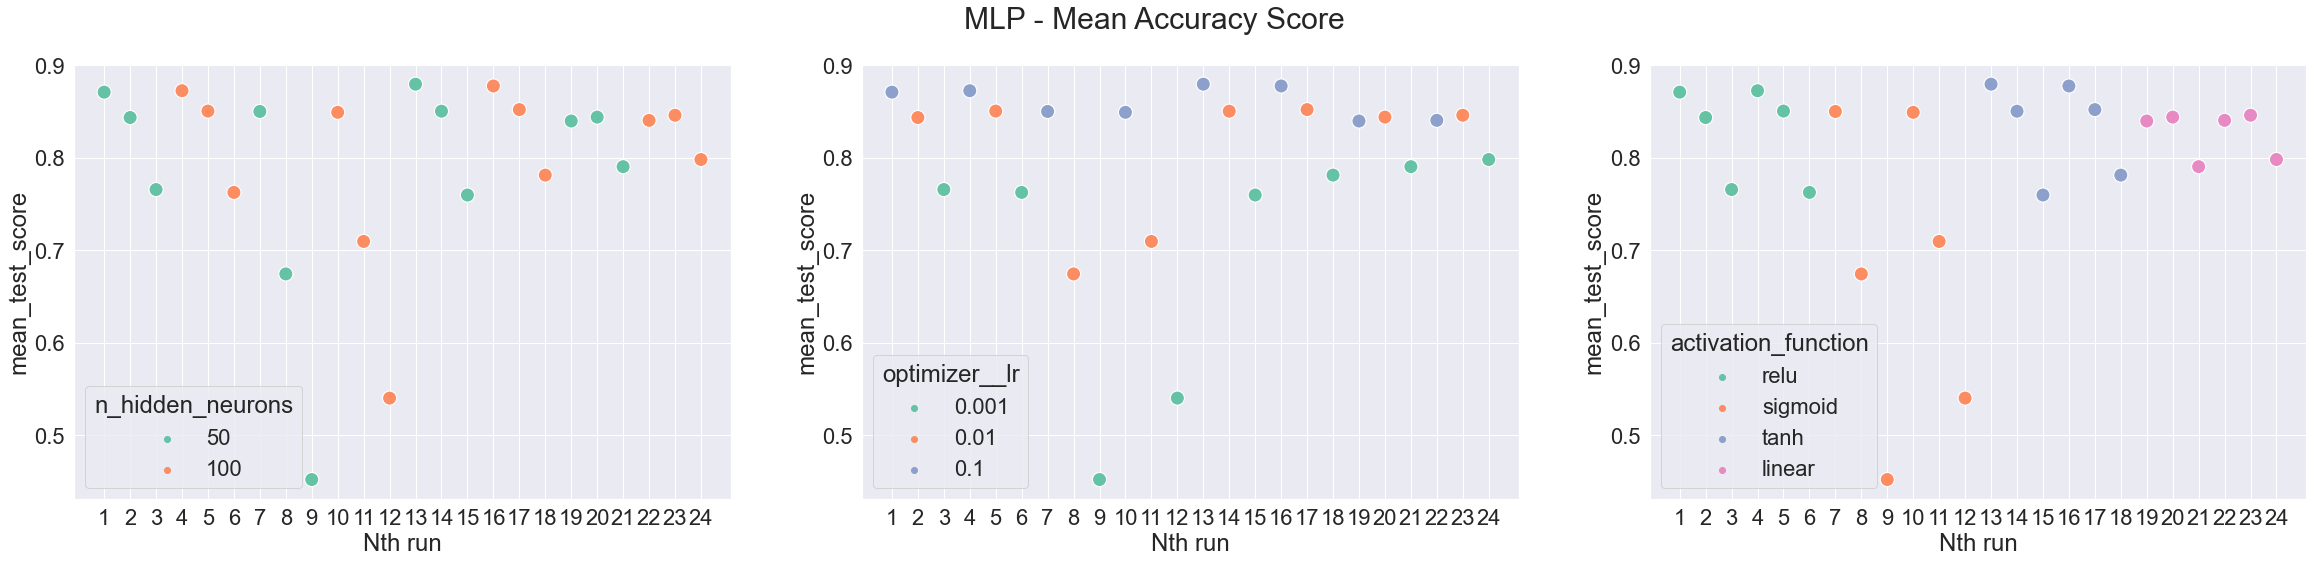

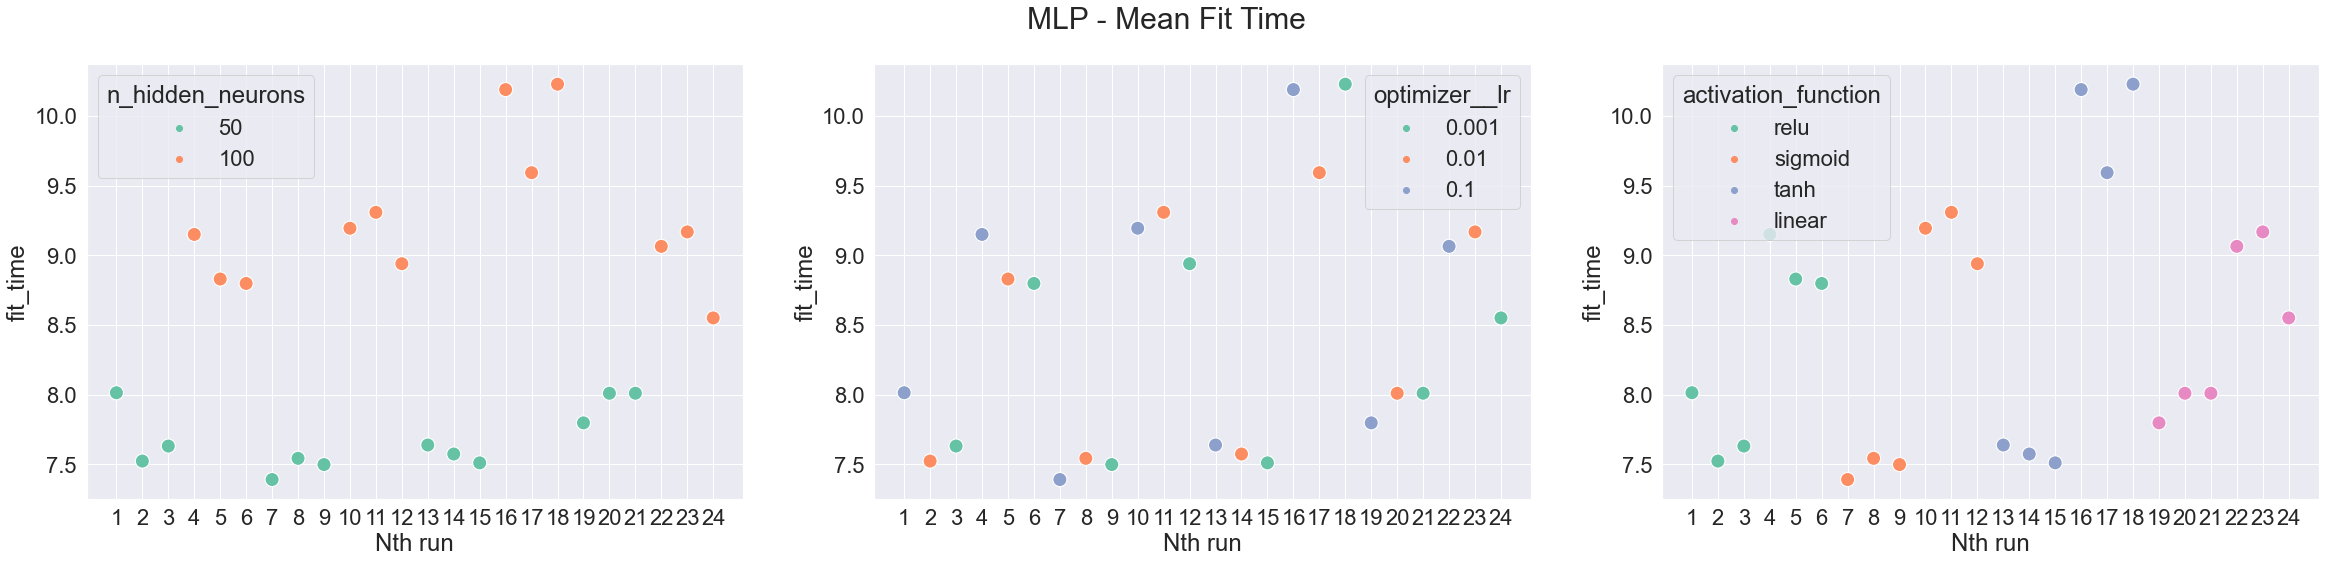

In [234]:
fig, ax = plt.subplots(1, 3, figsize = (40,8))

for i in range(len(param_grid_mlp.keys())):
    sns.set(font_scale=2)
    sns.scatterplot(x = mlp_search_df.index+1, y = mlp_search_df['mean_test_score'], 
                    hue = mlp_search_df[list(param_grid_mlp.keys())[i]], 
                    palette = 'Set2', s = 200, ax = ax[i])
    ax[i].set(xlabel = 'Nth run')
    ax[i].set_xticks(mlp_search_df.index+1)
plt.suptitle('MLP - Mean Accuracy Score',fontsize = 30)
plt.savefig('mlp_accuracy.jpg')
    
fig, ax = plt.subplots(1, 3, figsize = (40,8))    
for i in range(len(param_grid_mlp.keys())):
    sns.set(font_scale=2)
    sns.scatterplot(x = mlp_search_df.index+1, y = mlp_search_df['fit_time'], 
                    hue = mlp_search_df[list(param_grid_mlp.keys())[i]], 
                    palette = 'Set2', s = 200, ax = ax[i])
    ax[i].set(xlabel = 'Nth run')
    ax[i].set_xticks(mlp_search_df.index+1)
plt.suptitle('MLP - Mean Fit Time', fontsize = 30);
plt.savefig('mlp_runtime.jpg')

In [430]:
print('Mean result by number of hidden neurons:')
mlp_search_df.groupby(by = 'n_hidden_neurons').mean()[['fit_time','mean_test_score']]

Mean result by number of hidden neurons:


,fit_time,mean_test_score
n_hidden_neurons,,
50,7.6794,0.7851
100,9.2518,0.7983


In [432]:
print('Mean result by learning rate:')
mlp_search_df.groupby(by = 'optimizer__lr').mean()[['fit_time','mean_test_score']]

Mean result by learning rate:


,fit_time,mean_test_score
optimizer__lr,,
0.001,8.3967,0.7063
0.010,8.4445,0.8088
0.100,8.5556,0.8600


In [433]:
print('Mean result by activation function:')
mlp_search_df.groupby(by = 'activation_function').mean()[['fit_time','mean_test_score']]

Mean result by activation function:


,fit_time,mean_test_score
activation_function,,
linear,8.4343,0.8264
relu,8.3252,0.8276
sigmoid,8.3133,0.6794
tanh,8.7897,0.8334


In [527]:
mlp_final_params = history_mlp_cv.best_params_
print('Best MLP model parameters:', mlp_final_params)

Best MLP model parameters: {'activation_function': 'tanh', 'n_hidden_neurons': 50, 'optimizer__lr': 0.1}


### Convolutional neural network

In [390]:
# Using full training set for cross validation
X_train_cnn_gridsearch = np.expand_dims(X_train_full, -1)

In [401]:
tf.random.set_seed(42)
keras.backend.clear_session()


In [402]:

def build_cnn(kernel_size = (3,3), strides = (2,2), pool_size = (2,2),
    activation_function="relu", input_shape=(28,28,1)):

    model = keras.models.Sequential()
    
    model.add(keras.layers.Input(shape = input_shape))


    model.add(keras.layers.Conv2D(filters = 32, 
                                  strides = strides,
                                  kernel_size = kernel_size,
                                  activation=activation_function))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
 
    model.add(keras.layers.Conv2D(filters = 64, 
                                  strides = strides,
                                  kernel_size = kernel_size,
                                  activation=activation_function))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
  
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(10, activation="softmax"))
    
    return model


In [403]:
build_cnn().summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0

In [404]:
keras_classifier_cnn = KerasClassifier(build_cnn,
                                   activation_function="relu",
                                   kernel_size = (3,3),
                                   strides = (2,2),
                                   pool_size = (2,2),
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="adam",
                                   optimizer__lr=0.01,
                                   metrics=["accuracy"]
                                  )


In [405]:
param_grid_cnn = {
    "optimizer__lr": [0.1, 0.01, 0.001],
    'kernel_size':[(3,3),(4,4)],
    'strides':[(2,2),(1,1)]
}

start = timeit.default_timer()

grid_search_cv_cnn = GridSearchCV(keras_classifier_cnn, param_grid_cnn, cv=cvKFold, verbose=2)
grid_search_cv_cnn.fit(X_train_cnn_gridsearch, y_train_full, batch_size = 128, epochs=15)

stop = timeit.default_timer()
print('CNN grid search runtime in seconds: ', stop - start) 
print(grid_search_cv_cnn.best_params_)
print(grid_search_cv_cnn.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 8ms/step - loss: 2.3874 - accuracy: 0.0979
Epoch 2/15
313/313 [==============================] - 2s 6ms/step - loss: 2.3086 - accuracy: 0.0992
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3085 - accuracy: 0.1009
Epoch 4/15
313/313 [==============================] - 2s 6ms/step - loss: 2.3084 - accuracy: 0.1009
Epoch 5/15
313/313 [==============================] - 2s 6ms/step - loss: 2.3095 - accuracy: 0.0976
Epoch 6/15
313/313 [==============================] - 2s 6ms/step - loss: 2.3088 - accuracy: 0.0983
Epoch 7/15
313/313 [==============================] - 2s 6ms/step - loss: 2.3084 - accuracy: 0.1002
Epoch 8/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3088 - accuracy: 0.0996
Epoch 9/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3090 - accuracy: 0.0992
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3088 - accuracy: 0.0979

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 8ms/step - loss: 1.5304 - accuracy: 0.4370
Epoch 2/15
313/313 [==============================] - 2s 6ms/step - loss: 1.3595 - accuracy: 0.4947
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 1.3566 - accuracy: 0.4902
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 1.3477 - accuracy: 0.4938
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 1.3671 - accuracy: 0.4866
Epoch 6/15
313/313 [==============================] - 2s 8ms/step - loss: 1.3678 - accuracy: 0.4842
Epoch 7/15
313/313 [==============================] - 2s 7ms/step - loss: 1.3589 - accuracy: 0.4867
Epoch 8/15
313/313 [==============================] - 2s 7ms/step - loss: 1.3679 - accuracy: 0.4884
Epoch 9/15
313/313 [==============================] - 2s 7ms/step - loss: 1.3888 - accuracy: 0.4798
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 1.4133 - accuracy: 0.4676

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 7ms/step - loss: 2.3262 - accuracy: 0.0994
Epoch 2/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3080 - accuracy: 0.0999
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3085 - accuracy: 0.0992
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3083 - accuracy: 0.0987
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3082 - accuracy: 0.0988
Epoch 6/15
313/313 [==============================] - 2s 6ms/step - loss: 2.3091 - accuracy: 0.0974
Epoch 7/15
313/313 [==============================] - 2s 6ms/step - loss: 2.3097 - accuracy: 0.0991
Epoch 8/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3083 - accuracy: 0.1022
Epoch 9/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3078 - accuracy: 0.1015
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3086 - accuracy: 0.0989

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 13s 40ms/step - loss: 1.4640 - accuracy: 0.6122
Epoch 2/15
313/313 [==============================] - 12s 38ms/step - loss: 0.8197 - accuracy: 0.6992
Epoch 3/15
313/313 [==============================] - 11s 35ms/step - loss: 0.7985 - accuracy: 0.7028
Epoch 4/15
313/313 [==============================] - 12s 37ms/step - loss: 0.8362 - accuracy: 0.6881
Epoch 5/15
313/313 [==============================] - 11s 37ms/step - loss: 0.8244 - accuracy: 0.6923
Epoch 6/15
313/313 [==============================] - 11s 34ms/step - loss: 0.8312 - accuracy: 0.6920
Epoch 7/15
313/313 [==============================] - 10s 32ms/step - loss: 0.8084 - accuracy: 0.6967
Epoch 8/15
313/313 [==============================] - 10s 31ms/step - loss: 0.8342 - accuracy: 0.6900
Epoch 9/15
313/313 [==============================] - 10s 32ms/step - loss: 0.8546 - accuracy: 0.6823
Epoch 10/15
313/313 [==============================] - 10s 32ms/step - loss: 0.839

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 13s 40ms/step - loss: 2.5648 - accuracy: 0.1004
Epoch 2/15
313/313 [==============================] - 11s 34ms/step - loss: 2.3079 - accuracy: 0.1008
Epoch 3/15
313/313 [==============================] - 10s 33ms/step - loss: 2.3085 - accuracy: 0.0992
Epoch 4/15
313/313 [==============================] - 10s 34ms/step - loss: 2.3088 - accuracy: 0.0982
Epoch 5/15
313/313 [==============================] - 11s 36ms/step - loss: 2.3088 - accuracy: 0.1026
Epoch 6/15
313/313 [==============================] - 10s 33ms/step - loss: 2.3086 - accuracy: 0.1010
Epoch 7/15
313/313 [==============================] - 12s 39ms/step - loss: 2.3081 - accuracy: 0.0975
Epoch 8/15
313/313 [==============================] - 10s 33ms/step - loss: 2.3095 - accuracy: 0.0984
Epoch 9/15
313/313 [==============================] - 12s 38ms/step - loss: 2.3086 - accuracy: 0.0999
Epoch 10/15
313/313 [==============================] - 11s 37ms/step - loss: 2.309

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 13s 40ms/step - loss: 2.6108 - accuracy: 0.0991
Epoch 2/15
313/313 [==============================] - 11s 36ms/step - loss: 2.3076 - accuracy: 0.1000
Epoch 3/15
313/313 [==============================] - 11s 35ms/step - loss: 2.3083 - accuracy: 0.0990
Epoch 4/15
313/313 [==============================] - 11s 36ms/step - loss: 2.3082 - accuracy: 0.0993
Epoch 5/15
313/313 [==============================] - 11s 35ms/step - loss: 2.3081 - accuracy: 0.0986
Epoch 6/15
313/313 [==============================] - 12s 39ms/step - loss: 2.3091 - accuracy: 0.0976
Epoch 7/15
313/313 [==============================] - 10s 33ms/step - loss: 2.3096 - accuracy: 0.0995
Epoch 8/15
313/313 [==============================] - 10s 32ms/step - loss: 2.3083 - accuracy: 0.1023
Epoch 9/15
313/313 [==============================] - 10s 34ms/step - loss: 2.3078 - accuracy: 0.1017
Epoch 10/15
313/313 [==============================] - 11s 35ms/step - loss: 2.308

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 8ms/step - loss: 0.8437 - accuracy: 0.6940
Epoch 2/15
313/313 [==============================] - 2s 8ms/step - loss: 0.6282 - accuracy: 0.7737
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5895 - accuracy: 0.7872
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5722 - accuracy: 0.7915
Epoch 5/15
313/313 [==============================] - 2s 6ms/step - loss: 0.5500 - accuracy: 0.7988
Epoch 6/15
313/313 [==============================] - 2s 6ms/step - loss: 0.5419 - accuracy: 0.8008
Epoch 7/15
313/313 [==============================] - 2s 6ms/step - loss: 0.5316 - accuracy: 0.8057
Epoch 8/15
313/313 [==============================] - 2s 6ms/step - loss: 0.5237 - accuracy: 0.8088
Epoch 9/15
313/313 [==============================] - 2s 6ms/step - loss: 0.5137 - accuracy: 0.8115
Epoch 10/15
313/313 [==============================] - 2s 6ms/step - loss: 0.5139 - accuracy: 0.8102

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 9ms/step - loss: 0.8923 - accuracy: 0.6803
Epoch 2/15
313/313 [==============================] - 2s 6ms/step - loss: 0.6553 - accuracy: 0.7637
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6155 - accuracy: 0.7797
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5977 - accuracy: 0.7858
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5791 - accuracy: 0.7910
Epoch 6/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5704 - accuracy: 0.7944
Epoch 7/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5577 - accuracy: 0.7974
Epoch 8/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5512 - accuracy: 0.8011
Epoch 9/15
313/313 [==============================] - 3s 8ms/step - loss: 0.5421 - accuracy: 0.8043
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5390 - accuracy: 0.8039

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 8ms/step - loss: 0.9429 - accuracy: 0.6526
Epoch 2/15
313/313 [==============================] - 2s 7ms/step - loss: 0.7067 - accuracy: 0.7434
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6540 - accuracy: 0.7614
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6265 - accuracy: 0.7714
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6105 - accuracy: 0.7780
Epoch 6/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6044 - accuracy: 0.7783
Epoch 7/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5880 - accuracy: 0.7848
Epoch 8/15
313/313 [==============================] - 2s 6ms/step - loss: 0.5812 - accuracy: 0.7872
Epoch 9/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5702 - accuracy: 0.7930
Epoch 10/15
313/313 [==============================] - 2s 6ms/step - loss: 0.5615 - accuracy: 0.7956

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 13s 39ms/step - loss: 0.5565 - accuracy: 0.7987
Epoch 2/15
313/313 [==============================] - 12s 38ms/step - loss: 0.4225 - accuracy: 0.8456
Epoch 3/15
313/313 [==============================] - 13s 41ms/step - loss: 0.3896 - accuracy: 0.8575
Epoch 4/15
313/313 [==============================] - 13s 40ms/step - loss: 0.3721 - accuracy: 0.8618
Epoch 5/15
313/313 [==============================] - 13s 41ms/step - loss: 0.3614 - accuracy: 0.8673
Epoch 6/15
313/313 [==============================] - 11s 34ms/step - loss: 0.3558 - accuracy: 0.8687
Epoch 7/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3471 - accuracy: 0.8715
Epoch 8/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3332 - accuracy: 0.8760
Epoch 9/15
313/313 [==============================] - 11s 35ms/step - loss: 0.3344 - accuracy: 0.8770
Epoch 10/15
313/313 [==============================] - 11s 35ms/step - loss: 0.333

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 13s 41ms/step - loss: 0.5539 - accuracy: 0.7988
Epoch 2/15
313/313 [==============================] - 11s 35ms/step - loss: 0.4166 - accuracy: 0.8484
Epoch 3/15
313/313 [==============================] - 11s 34ms/step - loss: 0.3856 - accuracy: 0.8606
Epoch 4/15
313/313 [==============================] - 11s 35ms/step - loss: 0.3719 - accuracy: 0.8627
Epoch 5/15
313/313 [==============================] - 11s 34ms/step - loss: 0.3656 - accuracy: 0.8670
Epoch 6/15
313/313 [==============================] - 11s 34ms/step - loss: 0.3565 - accuracy: 0.8688
Epoch 7/15
313/313 [==============================] - 11s 35ms/step - loss: 0.3476 - accuracy: 0.8735
Epoch 8/15
313/313 [==============================] - 12s 38ms/step - loss: 0.3423 - accuracy: 0.8763
Epoch 9/15
313/313 [==============================] - 12s 37ms/step - loss: 0.3389 - accuracy: 0.8769
Epoch 10/15
313/313 [==============================] - 11s 34ms/step - loss: 0.338

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 12s 37ms/step - loss: 0.5654 - accuracy: 0.7954
Epoch 2/15
313/313 [==============================] - 10s 33ms/step - loss: 0.4219 - accuracy: 0.8454
Epoch 3/15
313/313 [==============================] - 11s 35ms/step - loss: 0.3908 - accuracy: 0.8555
Epoch 4/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3745 - accuracy: 0.8604
Epoch 5/15
313/313 [==============================] - 11s 34ms/step - loss: 0.3631 - accuracy: 0.8662
Epoch 6/15
313/313 [==============================] - 12s 39ms/step - loss: 0.3548 - accuracy: 0.8673
Epoch 7/15
313/313 [==============================] - 14s 43ms/step - loss: 0.3517 - accuracy: 0.8711
Epoch 8/15
313/313 [==============================] - 12s 39ms/step - loss: 0.3480 - accuracy: 0.8709
Epoch 9/15
313/313 [==============================] - 12s 37ms/step - loss: 0.3402 - accuracy: 0.8734
Epoch 10/15
313/313 [==============================] - 12s 38ms/step - loss: 0.341

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 8ms/step - loss: 1.2349 - accuracy: 0.5767
Epoch 2/15
313/313 [==============================] - 2s 7ms/step - loss: 0.7855 - accuracy: 0.7225
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 0.7030 - accuracy: 0.7503
Epoch 4/15
313/313 [==============================] - 3s 9ms/step - loss: 0.6556 - accuracy: 0.7678
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6250 - accuracy: 0.7807
Epoch 6/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6033 - accuracy: 0.7886
Epoch 7/15
313/313 [==============================] - 3s 8ms/step - loss: 0.5857 - accuracy: 0.7948
Epoch 8/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5668 - accuracy: 0.7990
Epoch 9/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5577 - accuracy: 0.8016
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5487 - accuracy: 0.8048

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 7ms/step - loss: 1.2487 - accuracy: 0.5649
Epoch 2/15
313/313 [==============================] - 2s 6ms/step - loss: 0.7976 - accuracy: 0.7174
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 0.7170 - accuracy: 0.7468
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6650 - accuracy: 0.7660
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6353 - accuracy: 0.7749
Epoch 6/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6131 - accuracy: 0.7844
Epoch 7/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5963 - accuracy: 0.7889
Epoch 8/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5771 - accuracy: 0.7951
Epoch 9/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5652 - accuracy: 0.8001
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5586 - accuracy: 0.8023

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 7ms/step - loss: 1.2714 - accuracy: 0.5648
Epoch 2/15
313/313 [==============================] - 2s 7ms/step - loss: 0.7919 - accuracy: 0.7228
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 0.7143 - accuracy: 0.7485
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6698 - accuracy: 0.7620
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6375 - accuracy: 0.7745
Epoch 6/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6158 - accuracy: 0.7829
Epoch 7/15
313/313 [==============================] - 2s 8ms/step - loss: 0.5971 - accuracy: 0.7911
Epoch 8/15
313/313 [==============================] - 3s 10ms/step - loss: 0.5838 - accuracy: 0.7929
Epoch 9/15
313/313 [==============================] - 2s 8ms/step - loss: 0.5680 - accuracy: 0.7996
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5583 - accuracy: 0.800

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 13s 39ms/step - loss: 0.7500 - accuracy: 0.7284
Epoch 2/15
313/313 [==============================] - 11s 36ms/step - loss: 0.4697 - accuracy: 0.8296
Epoch 3/15
313/313 [==============================] - 14s 45ms/step - loss: 0.4223 - accuracy: 0.8491
Epoch 4/15
313/313 [==============================] - 13s 41ms/step - loss: 0.3912 - accuracy: 0.8586
Epoch 5/15
313/313 [==============================] - 12s 39ms/step - loss: 0.3726 - accuracy: 0.8666
Epoch 6/15
313/313 [==============================] - 12s 39ms/step - loss: 0.3546 - accuracy: 0.8729
Epoch 7/15
313/313 [==============================] - 12s 37ms/step - loss: 0.3429 - accuracy: 0.8755
Epoch 8/15
313/313 [==============================] - 13s 41ms/step - loss: 0.3309 - accuracy: 0.8784
Epoch 9/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3209 - accuracy: 0.8821
Epoch 10/15
313/313 [==============================] - 12s 38ms/step - loss: 0.311

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 14s 42ms/step - loss: 0.7614 - accuracy: 0.7258
Epoch 2/15
313/313 [==============================] - 12s 38ms/step - loss: 0.4886 - accuracy: 0.8239
Epoch 3/15
313/313 [==============================] - 12s 39ms/step - loss: 0.4327 - accuracy: 0.8471
Epoch 4/15
313/313 [==============================] - 14s 45ms/step - loss: 0.4062 - accuracy: 0.8542
Epoch 5/15
313/313 [==============================] - 14s 44ms/step - loss: 0.3851 - accuracy: 0.8627
Epoch 6/15
313/313 [==============================] - 12s 38ms/step - loss: 0.3685 - accuracy: 0.8691
Epoch 7/15
313/313 [==============================] - 12s 38ms/step - loss: 0.3533 - accuracy: 0.8740
Epoch 8/15
313/313 [==============================] - 12s 40ms/step - loss: 0.3459 - accuracy: 0.8758
Epoch 9/15
313/313 [==============================] - 12s 37ms/step - loss: 0.3330 - accuracy: 0.8808
Epoch 10/15
313/313 [==============================] - 12s 39ms/step - loss: 0.325

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 15s 45ms/step - loss: 0.7405 - accuracy: 0.7328
Epoch 2/15
313/313 [==============================] - 12s 39ms/step - loss: 0.4771 - accuracy: 0.8256
Epoch 3/15
313/313 [==============================] - 12s 38ms/step - loss: 0.4246 - accuracy: 0.8470
Epoch 4/15
313/313 [==============================] - 12s 40ms/step - loss: 0.3937 - accuracy: 0.8572
Epoch 5/15
313/313 [==============================] - 12s 39ms/step - loss: 0.3718 - accuracy: 0.8669
Epoch 6/15
313/313 [==============================] - 12s 37ms/step - loss: 0.3553 - accuracy: 0.8727
Epoch 7/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3421 - accuracy: 0.8753
Epoch 8/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3318 - accuracy: 0.8810
Epoch 9/15
313/313 [==============================] - 12s 37ms/step - loss: 0.3201 - accuracy: 0.8856
Epoch 10/15
313/313 [==============================] - 12s 38ms/step - loss: 0.310

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 8ms/step - loss: 2.4586 - accuracy: 0.0990
Epoch 2/15
313/313 [==============================] - 2s 8ms/step - loss: 2.3086 - accuracy: 0.0992
Epoch 3/15
313/313 [==============================] - 2s 8ms/step - loss: 2.3084 - accuracy: 0.1010
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3084 - accuracy: 0.1007
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3095 - accuracy: 0.0975
Epoch 6/15
313/313 [==============================] - 3s 8ms/step - loss: 2.3088 - accuracy: 0.0982
Epoch 7/15
313/313 [==============================] - 2s 8ms/step - loss: 2.3084 - accuracy: 0.1002
Epoch 8/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3088 - accuracy: 0.0996
Epoch 9/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3090 - accuracy: 0.0993
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3088 - accuracy: 0.0981

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 7ms/step - loss: 2.4128 - accuracy: 0.1000
Epoch 2/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3080 - accuracy: 0.1007
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3086 - accuracy: 0.0992
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3089 - accuracy: 0.0980
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3088 - accuracy: 0.1024
Epoch 6/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3086 - accuracy: 0.1010
Epoch 7/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3081 - accuracy: 0.0980
Epoch 8/15
313/313 [==============================] - 2s 8ms/step - loss: 2.3095 - accuracy: 0.0984
Epoch 9/15
313/313 [==============================] - 2s 8ms/step - loss: 2.3086 - accuracy: 0.1001
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3090 - accuracy: 0.0998

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 8ms/step - loss: 2.4341 - accuracy: 0.0985
Epoch 2/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3079 - accuracy: 0.1001
Epoch 3/15
313/313 [==============================] - 2s 8ms/step - loss: 2.3085 - accuracy: 0.0992
Epoch 4/15
313/313 [==============================] - 2s 8ms/step - loss: 2.3083 - accuracy: 0.0989
Epoch 5/15
313/313 [==============================] - 2s 8ms/step - loss: 2.3081 - accuracy: 0.0989
Epoch 6/15
313/313 [==============================] - 2s 8ms/step - loss: 2.3091 - accuracy: 0.0973
Epoch 7/15
313/313 [==============================] - 2s 8ms/step - loss: 2.3097 - accuracy: 0.0988
Epoch 8/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3083 - accuracy: 0.1022
Epoch 9/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3078 - accuracy: 0.1015
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 2.3086 - accuracy: 0.0989

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 13s 38ms/step - loss: 2.1017 - accuracy: 0.6072
Epoch 2/15
313/313 [==============================] - 13s 42ms/step - loss: 0.8408 - accuracy: 0.6859
Epoch 3/15
313/313 [==============================] - 13s 41ms/step - loss: 0.8330 - accuracy: 0.6902
Epoch 4/15
313/313 [==============================] - 14s 43ms/step - loss: 0.8080 - accuracy: 0.6946
Epoch 5/15
313/313 [==============================] - 13s 42ms/step - loss: 0.8343 - accuracy: 0.6847
Epoch 6/15
313/313 [==============================] - 13s 43ms/step - loss: 0.8572 - accuracy: 0.6772
Epoch 7/15
313/313 [==============================] - 13s 42ms/step - loss: 0.8242 - accuracy: 0.6850
Epoch 8/15
313/313 [==============================] - 13s 42ms/step - loss: 0.8355 - accuracy: 0.6823
Epoch 9/15
313/313 [==============================] - 13s 43ms/step - loss: 0.8543 - accuracy: 0.6792
Epoch 10/15
313/313 [==============================] - 13s 41ms/step - loss: 0.846

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 13s 41ms/step - loss: 3.1796 - accuracy: 0.1013
Epoch 2/15
313/313 [==============================] - 12s 40ms/step - loss: 2.3078 - accuracy: 0.1000
Epoch 3/15
313/313 [==============================] - 14s 46ms/step - loss: 2.3084 - accuracy: 0.0988
Epoch 4/15
313/313 [==============================] - 13s 40ms/step - loss: 2.3087 - accuracy: 0.0984
Epoch 5/15
313/313 [==============================] - 13s 42ms/step - loss: 2.3087 - accuracy: 0.1020
Epoch 6/15
313/313 [==============================] - 13s 40ms/step - loss: 2.3086 - accuracy: 0.1010
Epoch 7/15
313/313 [==============================] - 12s 39ms/step - loss: 2.3081 - accuracy: 0.0979
Epoch 8/15
313/313 [==============================] - 12s 40ms/step - loss: 2.3095 - accuracy: 0.0984
Epoch 9/15
313/313 [==============================] - 12s 39ms/step - loss: 2.3086 - accuracy: 0.1001
Epoch 10/15
313/313 [==============================] - 12s 38ms/step - loss: 2.309

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 11s 34ms/step - loss: 1.9559 - accuracy: 0.5520
Epoch 2/15
313/313 [==============================] - 11s 37ms/step - loss: 0.8945 - accuracy: 0.6708
Epoch 3/15
313/313 [==============================] - 12s 38ms/step - loss: 0.8848 - accuracy: 0.6730
Epoch 4/15
313/313 [==============================] - 12s 38ms/step - loss: 0.8984 - accuracy: 0.6660
Epoch 5/15
313/313 [==============================] - 13s 41ms/step - loss: 0.8847 - accuracy: 0.6698
Epoch 6/15
313/313 [==============================] - 12s 39ms/step - loss: 0.9123 - accuracy: 0.6644
Epoch 7/15
313/313 [==============================] - 12s 38ms/step - loss: 0.9136 - accuracy: 0.6603
Epoch 8/15
313/313 [==============================] - 12s 37ms/step - loss: 0.9131 - accuracy: 0.6596
Epoch 9/15
313/313 [==============================] - 12s 37ms/step - loss: 0.9179 - accuracy: 0.6611
Epoch 10/15
313/313 [==============================] - 12s 37ms/step - loss: 0.909

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 8ms/step - loss: 0.7416 - accuracy: 0.7322
Epoch 2/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5548 - accuracy: 0.7992
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5176 - accuracy: 0.8141
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4952 - accuracy: 0.8206
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4756 - accuracy: 0.8255
Epoch 6/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4624 - accuracy: 0.8304
Epoch 7/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4457 - accuracy: 0.8352
Epoch 8/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4373 - accuracy: 0.8379
Epoch 9/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4324 - accuracy: 0.8410
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4228 - accuracy: 0.8458

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 8ms/step - loss: 0.7837 - accuracy: 0.7149
Epoch 2/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5777 - accuracy: 0.7890
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5301 - accuracy: 0.8056
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5047 - accuracy: 0.8133
Epoch 5/15
313/313 [==============================] - 2s 8ms/step - loss: 0.4815 - accuracy: 0.8215
Epoch 6/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4696 - accuracy: 0.8255
Epoch 7/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4510 - accuracy: 0.8313
Epoch 8/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4514 - accuracy: 0.8320
Epoch 9/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4439 - accuracy: 0.8350
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4390 - accuracy: 0.8347

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 7ms/step - loss: 0.7545 - accuracy: 0.7256
Epoch 2/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5503 - accuracy: 0.7979
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5072 - accuracy: 0.8152
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4795 - accuracy: 0.8219
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4644 - accuracy: 0.8291
Epoch 6/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4551 - accuracy: 0.8319
Epoch 7/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4447 - accuracy: 0.8346
Epoch 8/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4372 - accuracy: 0.8365
Epoch 9/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4305 - accuracy: 0.8401
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4233 - accuracy: 0.8430

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 12s 36ms/step - loss: 0.6035 - accuracy: 0.7789
Epoch 2/15
313/313 [==============================] - 12s 38ms/step - loss: 0.4602 - accuracy: 0.8322
Epoch 3/15
313/313 [==============================] - 12s 38ms/step - loss: 0.4227 - accuracy: 0.8423
Epoch 4/15
313/313 [==============================] - 12s 38ms/step - loss: 0.4130 - accuracy: 0.8479
Epoch 5/15
313/313 [==============================] - 12s 38ms/step - loss: 0.4018 - accuracy: 0.8517
Epoch 6/15
313/313 [==============================] - 12s 38ms/step - loss: 0.3868 - accuracy: 0.8572
Epoch 7/15
313/313 [==============================] - 12s 37ms/step - loss: 0.3875 - accuracy: 0.8561
Epoch 8/15
313/313 [==============================] - 11s 37ms/step - loss: 0.3812 - accuracy: 0.8590
Epoch 9/15
313/313 [==============================] - 11s 37ms/step - loss: 0.3762 - accuracy: 0.8600
Epoch 10/15
313/313 [==============================] - 11s 36ms/step - loss: 0.373

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 12s 36ms/step - loss: 0.6225 - accuracy: 0.7733
Epoch 2/15
313/313 [==============================] - 11s 36ms/step - loss: 0.4626 - accuracy: 0.8311
Epoch 3/15
313/313 [==============================] - 12s 37ms/step - loss: 0.4292 - accuracy: 0.8437
Epoch 4/15
313/313 [==============================] - 12s 38ms/step - loss: 0.4116 - accuracy: 0.8492
Epoch 5/15
313/313 [==============================] - 12s 38ms/step - loss: 0.4017 - accuracy: 0.8540
Epoch 6/15
313/313 [==============================] - 12s 40ms/step - loss: 0.3971 - accuracy: 0.8543
Epoch 7/15
313/313 [==============================] - 12s 37ms/step - loss: 0.3791 - accuracy: 0.8605
Epoch 8/15
313/313 [==============================] - 12s 37ms/step - loss: 0.3794 - accuracy: 0.8600
Epoch 9/15
313/313 [==============================] - 11s 37ms/step - loss: 0.3723 - accuracy: 0.8615
Epoch 10/15
313/313 [==============================] - 11s 36ms/step - loss: 0.374

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 13s 39ms/step - loss: 0.6231 - accuracy: 0.7740
Epoch 2/15
313/313 [==============================] - 11s 36ms/step - loss: 0.4594 - accuracy: 0.8323
Epoch 3/15
313/313 [==============================] - 11s 37ms/step - loss: 0.4282 - accuracy: 0.8425
Epoch 4/15
313/313 [==============================] - 12s 38ms/step - loss: 0.4111 - accuracy: 0.8482
Epoch 5/15
313/313 [==============================] - 12s 38ms/step - loss: 0.4063 - accuracy: 0.8496
Epoch 6/15
313/313 [==============================] - 12s 38ms/step - loss: 0.4011 - accuracy: 0.8511
Epoch 7/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3892 - accuracy: 0.8561
Epoch 8/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3824 - accuracy: 0.8577
Epoch 9/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3786 - accuracy: 0.8589
Epoch 10/15
313/313 [==============================] - 11s 36ms/step - loss: 0.381

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 8ms/step - loss: 1.0669 - accuracy: 0.6313
Epoch 2/15
313/313 [==============================] - 3s 9ms/step - loss: 0.6790 - accuracy: 0.7585
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6067 - accuracy: 0.7836
Epoch 4/15
313/313 [==============================] - 2s 8ms/step - loss: 0.5629 - accuracy: 0.8024
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5306 - accuracy: 0.8144
Epoch 6/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5082 - accuracy: 0.8209
Epoch 7/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4898 - accuracy: 0.8279
Epoch 8/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4737 - accuracy: 0.8313
Epoch 9/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4628 - accuracy: 0.8370
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4474 - accuracy: 0.8414

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 7ms/step - loss: 1.0975 - accuracy: 0.6225
Epoch 2/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6861 - accuracy: 0.7581
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 0.6085 - accuracy: 0.7854
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5648 - accuracy: 0.7997
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5375 - accuracy: 0.8126
Epoch 6/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5170 - accuracy: 0.8205
Epoch 7/15
313/313 [==============================] - 3s 8ms/step - loss: 0.4979 - accuracy: 0.8249
Epoch 8/15
313/313 [==============================] - 2s 8ms/step - loss: 0.4831 - accuracy: 0.8315
Epoch 9/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4725 - accuracy: 0.8335
Epoch 10/15
313/313 [==============================] - 2s 8ms/step - loss: 0.4604 - accuracy: 0.8372

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 3s 8ms/step - loss: 1.0606 - accuracy: 0.6463
Epoch 2/15
313/313 [==============================] - 2s 8ms/step - loss: 0.6546 - accuracy: 0.7703
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5850 - accuracy: 0.7970
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5329 - accuracy: 0.8130
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 0.5074 - accuracy: 0.8217
Epoch 6/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4843 - accuracy: 0.8292
Epoch 7/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4677 - accuracy: 0.8334
Epoch 8/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4523 - accuracy: 0.8400
Epoch 9/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4416 - accuracy: 0.8438
Epoch 10/15
313/313 [==============================] - 2s 7ms/step - loss: 0.4298 - accuracy: 0.8470

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 12s 37ms/step - loss: 0.7945 - accuracy: 0.7166
Epoch 2/15
313/313 [==============================] - 12s 39ms/step - loss: 0.5229 - accuracy: 0.8079
Epoch 3/15
313/313 [==============================] - 12s 37ms/step - loss: 0.4592 - accuracy: 0.8307
Epoch 4/15
313/313 [==============================] - 12s 37ms/step - loss: 0.4202 - accuracy: 0.8473
Epoch 5/15
313/313 [==============================] - 12s 37ms/step - loss: 0.3962 - accuracy: 0.8559
Epoch 6/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3759 - accuracy: 0.8631
Epoch 7/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3623 - accuracy: 0.8703
Epoch 8/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3479 - accuracy: 0.8738
Epoch 9/15
313/313 [==============================] - 12s 38ms/step - loss: 0.3356 - accuracy: 0.8775
Epoch 10/15
313/313 [==============================] - 12s 37ms/step - loss: 0.330

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 12s 36ms/step - loss: 0.7925 - accuracy: 0.7147
Epoch 2/15
313/313 [==============================] - 13s 40ms/step - loss: 0.5066 - accuracy: 0.8180
Epoch 3/15
313/313 [==============================] - 11s 36ms/step - loss: 0.4445 - accuracy: 0.8411
Epoch 4/15
313/313 [==============================] - 12s 37ms/step - loss: 0.4138 - accuracy: 0.8525
Epoch 5/15
313/313 [==============================] - 11s 35ms/step - loss: 0.3865 - accuracy: 0.8615
Epoch 6/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3679 - accuracy: 0.8687
Epoch 7/15
313/313 [==============================] - 11s 35ms/step - loss: 0.3524 - accuracy: 0.8742
Epoch 8/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3409 - accuracy: 0.8777
Epoch 9/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3303 - accuracy: 0.8818
Epoch 10/15
313/313 [==============================] - 11s 35ms/step - loss: 0.322

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
313/313 [==============================] - 10s 31ms/step - loss: 0.7790 - accuracy: 0.7208
Epoch 2/15
313/313 [==============================] - 11s 35ms/step - loss: 0.4957 - accuracy: 0.8196
Epoch 3/15
313/313 [==============================] - 11s 36ms/step - loss: 0.4373 - accuracy: 0.8428
Epoch 4/15
313/313 [==============================] - 11s 36ms/step - loss: 0.4048 - accuracy: 0.8550
Epoch 5/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3819 - accuracy: 0.8610
Epoch 6/15
313/313 [==============================] - 11s 34ms/step - loss: 0.3625 - accuracy: 0.8665
Epoch 7/15
313/313 [==============================] - 11s 34ms/step - loss: 0.3503 - accuracy: 0.8722
Epoch 8/15
313/313 [==============================] - 11s 35ms/step - loss: 0.3392 - accuracy: 0.8773
Epoch 9/15
313/313 [==============================] - 11s 36ms/step - loss: 0.3290 - accuracy: 0.8792
Epoch 10/15
313/313 [==============================] - 11s 36ms/step - loss: 0.318

/Users/feihui/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
469/469 [==============================] - 17s 36ms/step - loss: 0.6691 - accuracy: 0.7576
Epoch 2/15
469/469 [==============================] - 15s 31ms/step - loss: 0.4472 - accuracy: 0.8383
Epoch 3/15
469/469 [==============================] - 15s 32ms/step - loss: 0.3986 - accuracy: 0.8555
Epoch 4/15
469/469 [==============================] - 15s 32ms/step - loss: 0.3668 - accuracy: 0.8673
Epoch 5/15
469/469 [==============================] - 17s 37ms/step - loss: 0.3446 - accuracy: 0.8761
Epoch 6/15
469/469 [==============================] - 16s 34ms/step - loss: 0.3278 - accuracy: 0.8798
Epoch 7/15
469/469 [==============================] - 15s 31ms/step - loss: 0.3165 - accuracy: 0.8848
Epoch 8/15
469/469 [==============================] - 15s 31ms/step - loss: 0.3073 - accuracy: 0.8892
Epoch 9/15
469/469 [==============================] - 16s 35ms/step - loss: 0.2979 - accuracy: 0.8918
Epoch 10/15
469/469 [==============================] - 17s 37ms/step - loss: 0.288

In [406]:
# putting parameter tuning results into a dataframe for easy comparison

cnn_search_df = pd.DataFrame({'parameters':grid_search_cv_cnn.cv_results_['params'],
                            'fit_time':grid_search_cv_cnn.cv_results_['mean_fit_time'],
                            'mean_test_score':grid_search_cv_cnn.cv_results_['mean_test_score']})

for para in param_grid_cnn.keys():
    cnn_search_df[para] = cnn_search_df['parameters'].apply(lambda x: x[para])
    
cnn_search_df.drop('parameters', axis = 1, inplace = True)



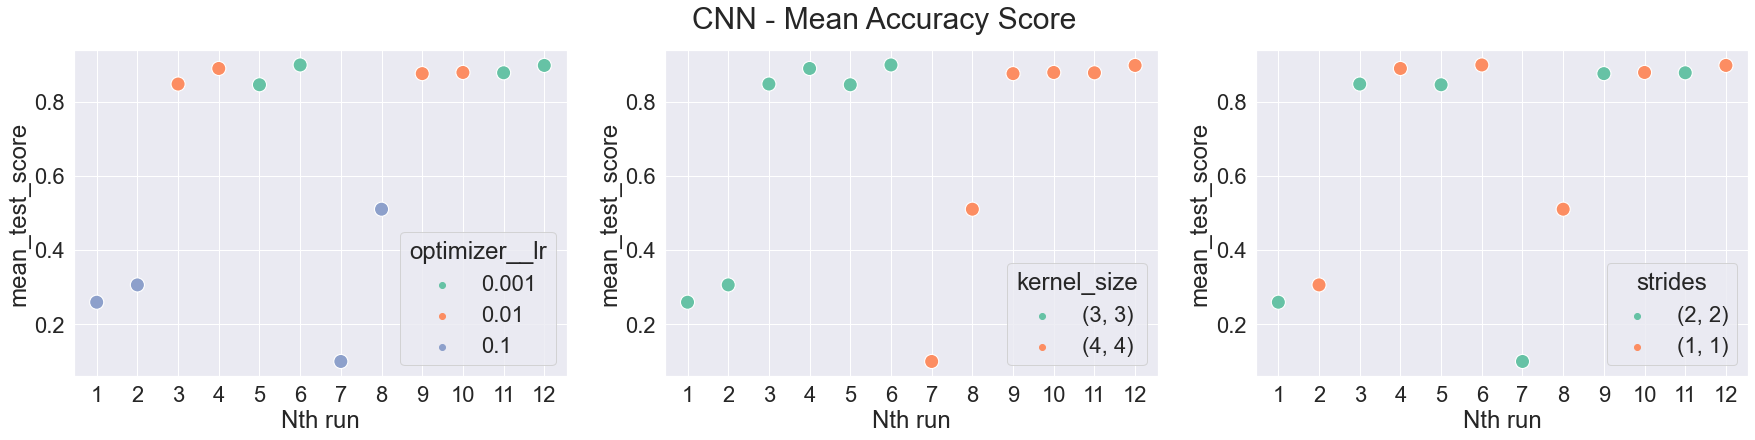

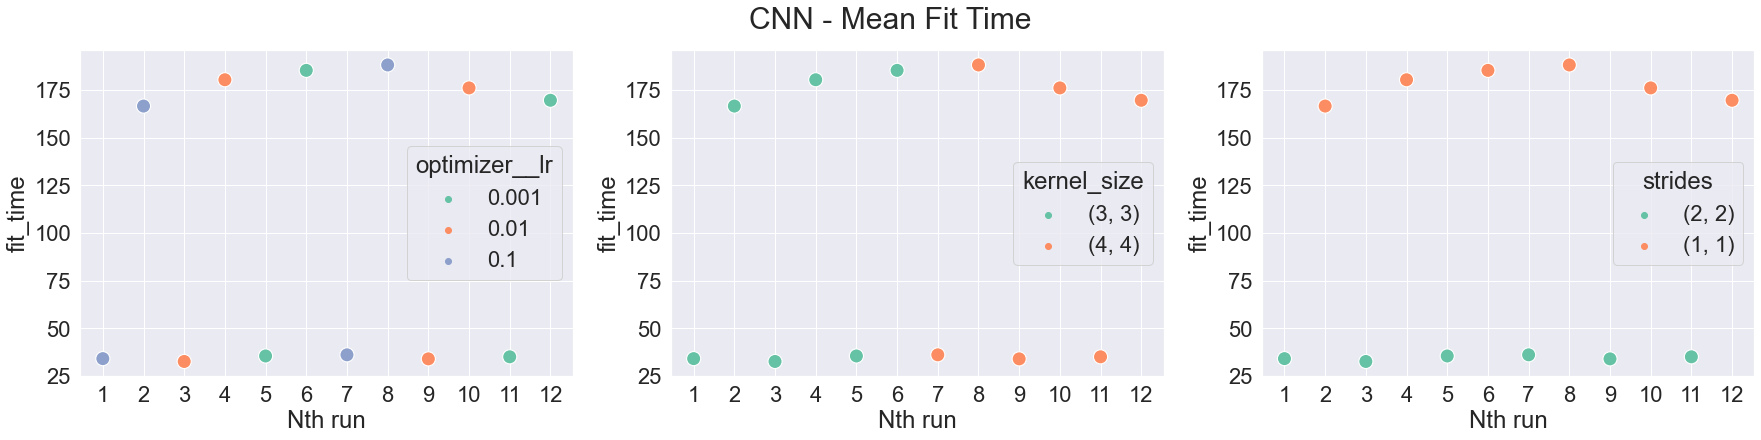

In [407]:
fig, ax = plt.subplots(1, 3, figsize = (30,6))

for i in range(len(param_grid_cnn.keys())):
    sns.set(font_scale=2)
    sns.scatterplot(x = cnn_search_df.index+1, y = cnn_search_df['mean_test_score'], 
                    hue = cnn_search_df[list(param_grid_cnn.keys())[i]], 
                    palette = 'Set2', s = 200, ax = ax[i])
    ax[i].set(xlabel = 'Nth run')
    ax[i].set_xticks(cnn_search_df.index+1)
plt.suptitle('CNN - Mean Accuracy Score',fontsize = 30)
plt.savefig('cnn_accuracy.jpg')
    
fig, ax = plt.subplots(1, 3, figsize = (30,6))    
for i in range(len(param_grid_cnn.keys())):
    sns.set(font_scale=2)
    sns.scatterplot(x = cnn_search_df.index+1, y = cnn_search_df['fit_time'], 
                    hue = cnn_search_df[list(param_grid_cnn.keys())[i]], 
                    palette = 'Set2', s = 200, ax = ax[i])
    ax[i].set(xlabel = 'Nth run')
    ax[i].set_xticks(cnn_search_df.index+1)
plt.suptitle('CNN - Mean Fit Time', fontsize = 30);
plt.savefig('cnn_runtime.jpg')


In [435]:
print('Mean result by learning rate:')
cnn_search_df.groupby(by = 'optimizer__lr').mean()[['fit_time','mean_test_score']]

Mean result by learning rate:


,fit_time,mean_test_score
optimizer__lr,,
0.001,106.4392,0.8804
0.010,105.8390,0.8732
0.100,106.3016,0.2942


In [436]:
print('Mean result by kernel size:')
cnn_search_df.groupby(by = 'kernel_size').mean()[['fit_time','mean_test_score']]

Mean result by kernel size:


,fit_time,mean_test_score
kernel_size,,
"(3, 3)",105.8166,0.6749
"(4, 4)",106.5700,0.6903


In [437]:
print('Mean result by strides:')
cnn_search_df.groupby(by = 'strides').mean()[['fit_time','mean_test_score']]

Mean result by strides:


,fit_time,mean_test_score
strides,,
"(1, 1)",177.7305,0.7306
"(2, 2)",34.6560,0.6346


In [536]:
cnn_final_params = grid_search_cv_cnn.best_params_
print('Best CNN model parameters:', cnn_final_params)

Best CNN model parameters: {'kernel_size': (3, 3), 'optimizer__lr': 0.001, 'strides': (1, 1)}


## Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Random forest (algorithm of choice from first six weeks of course)

In [520]:
#training on full train data
X_train_rf_final = X_train_full.copy()
X_train_rf_final = X_train_rf_final.reshape(60000, 28*28)

In [521]:
rf_final = RandomForestClassifier(criterion='entropy', max_depth=40, n_estimators=150,
                       random_state=0)

rf_fit_start = timeit.default_timer()

rf_final.fit(X_train_rf_final, y_train_full)

rf_fit_stop = timeit.default_timer()
rf_fittime = rf_fit_stop - rf_fit_start

print('Random forest final model fittime in seconds: ', rf_fittime) 

Random forest final model fittime in seconds:  115.19666944001801


In [522]:
#processing test data
X_test_rf = X_test/255
X_test_rf = X_test_rf.reshape(10000,28*28)


In [523]:
#predicting on test data
rf_pred = rf_final.predict(X_test_rf)


In [524]:
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='macro')
rf_precision = precision_score(y_test, rf_pred, average='macro')
rf_recall = recall_score(y_test, rf_pred, average='macro')

rf_cm = confusion_matrix(y_test, rf_pred, labels = range(0,10))

### Fully connected neural network

In [525]:
# training on full train data
X_train_mlp_final = X_train_full.copy()

In [526]:
#transforming test data
X_test_mlp = X_test.copy()
X_test_mlp = X_test_mlp/255

In [528]:
tf.random.set_seed(42)
keras.backend.clear_session()

mlp_final = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(50, activation="tanh"),
    keras.layers.Dense(50, activation="tanh"),
    keras.layers.Dense(10, activation="softmax")
])


mlp_final_opt = keras.optimizers.SGD(learning_rate=0.1)
mlp_final.compile(loss='sparse_categorical_crossentropy',
              optimizer=mlp_final_opt)

mlp_fit_start = timeit.default_timer()

mlp_final.fit(X_train_mlp_final, y_train_full, epochs=20)

mlp_fit_stop = timeit.default_timer()
mlp_fittime = mlp_fit_stop - mlp_fit_start

print('MLP final model fittime in seconds: ', mlp_fittime) 

Epoch 1/20
1875/1875 [==============================] - 2s 935us/step - loss: 0.5200
Epoch 2/20
1875/1875 [==============================] - 1s 795us/step - loss: 0.3976
Epoch 3/20
1875/1875 [==============================] - 1s 780us/step - loss: 0.3613
Epoch 4/20
1875/1875 [==============================] - 1s 780us/step - loss: 0.3390
Epoch 5/20
1875/1875 [==============================] - 1s 782us/step - loss: 0.3242
Epoch 6/20
1875/1875 [==============================] - 1s 780us/step - loss: 0.3094
Epoch 7/20
1875/1875 [==============================] - 2s 814us/step - loss: 0.2993
Epoch 8/20
1875/1875 [==============================] - 1s 782us/step - loss: 0.2898
Epoch 9/20
1875/1875 [==============================] - 1s 789us/step - loss: 0.2802
Epoch 10/20
1875/1875 [==============================] - 2s 802us/step - loss: 0.2732
Epoch 11/20
1875/1875 [==============================] - 1s 781us/step - loss: 0.2665
Epoch 12/20
1875/1875 [==============================] - 1s 784

In [529]:
mlp_proba = mlp_final.predict(X_test_mlp)
mlp_pred = np.argmax(mlp_proba, axis=-1)

In [530]:
mlp_accuracy = accuracy_score(y_test, mlp_pred)
mlp_f1 = f1_score(y_test, mlp_pred, average='macro')
mlp_precision = precision_score(y_test, mlp_pred, average='macro')
mlp_recall = recall_score(y_test, mlp_pred, average='macro')

mlp_cm = confusion_matrix(y_test, mlp_pred, labels = range(0,10))

### Convolutional neural network

In [534]:
# training on full data
X_train_cnn_final = X_train_full.copy()
X_train_cnn_final = np.expand_dims(X_train_cnn_final, -1)

In [535]:
#transforming test data
X_test_cnn = X_test.copy()
X_test_cnn = X_test_cnn/255
X_test_cnn = np.expand_dims(X_test_cnn, -1)

In [537]:
tf.random.set_seed(42)
keras.backend.clear_session()

cnn_final = keras.Sequential([
    
    # Specify the input shape
    keras.Input(shape=(28, 28, 1)),
    
    # Conv and pool block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3), strides = (1,1), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Conv and pool block 2
    keras.layers.Conv2D(64, kernel_size=(3, 3), strides = (1,1), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten and classify using dense output layer
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
])

cnn_final_opt = keras.optimizers.Adam(learning_rate=0.001)

cnn_final.compile(loss='sparse_categorical_crossentropy',
              optimizer=cnn_final_opt)

cnn_fit_start = timeit.default_timer()

cnn_final.fit(X_train_cnn_final, y_train_full, epochs=15)

cnn_fit_stop = timeit.default_timer()
cnn_fittime = cnn_fit_stop - cnn_fit_start

print('CNN final model fittime in seconds: ', cnn_fittime) 

Epoch 1/15
1875/1875 [==============================] - 22s 12ms/step - loss: 0.5543
Epoch 2/15
1875/1875 [==============================] - 23s 12ms/step - loss: 0.3951
Epoch 3/15
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3517
Epoch 4/15
1875/1875 [==============================] - 24s 13ms/step - loss: 0.3235
Epoch 5/15
1875/1875 [==============================] - 25s 13ms/step - loss: 0.3096
Epoch 6/15
1875/1875 [==============================] - 23s 12ms/step - loss: 0.2964
Epoch 7/15
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2875
Epoch 8/15
1875/1875 [==============================] - 23s 12ms/step - loss: 0.2783
Epoch 9/15
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2707
Epoch 10/15
1875/1875 [==============================] - 23s 12ms/step - loss: 0.2668
Epoch 11/15
1875/1875 [==============================] - 23s 12ms/step - loss: 0.2610
Epoch 12/15
1875/1875 [==============================] - 24s 13

In [538]:
cnn_proba = cnn_final.predict(X_test_cnn)
cnn_pred = np.argmax(cnn_proba, axis=-1)

In [539]:
cnn_accuracy = accuracy_score(y_test, cnn_pred)
cnn_f1 = f1_score(y_test, cnn_pred, average='macro')
cnn_precision = precision_score(y_test, cnn_pred, average='macro')
cnn_recall = recall_score(y_test, cnn_pred, average='macro')

cnn_cm = confusion_matrix(y_test, cnn_pred, labels = range(0,10))


### Putting it together

In [540]:
performance_df = pd.DataFrame({'Random forest':[rf_final_params, rf_accuracy, rf_f1, rf_precision, rf_recall, rf_fittime],
                             'MLP':[mlp_final_params,mlp_accuracy, mlp_f1, mlp_precision, mlp_recall, mlp_fittime],
                              'CNN':[cnn_final_params, cnn_accuracy, cnn_f1, cnn_precision, cnn_recall, cnn_fittime]},
                              index = ['Best parameter combination','Accuracy','F1','Precision','Recall','Training time (seconds)']
                             )

In [541]:
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', None)

performance_df.to_csv('table.csv')
performance_df


,Random forest,MLP,CNN
Best parameter combination,"{'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 150}","{'activation_function': 'tanh', 'n_hidden_neurons': 50, 'optimizer__lr': 0.1}","{'kernel_size': (3, 3), 'optimizer__lr': 0.001, 'strides': (1, 1)}"
Accuracy,0.8769,0.8764,0.9096
F1,0.8753,0.8737,0.9085
Precision,0.8758,0.8775,0.909
Recall,0.8769,0.8764,0.9096
Training time (seconds),115.1967,31.9887,347.1982


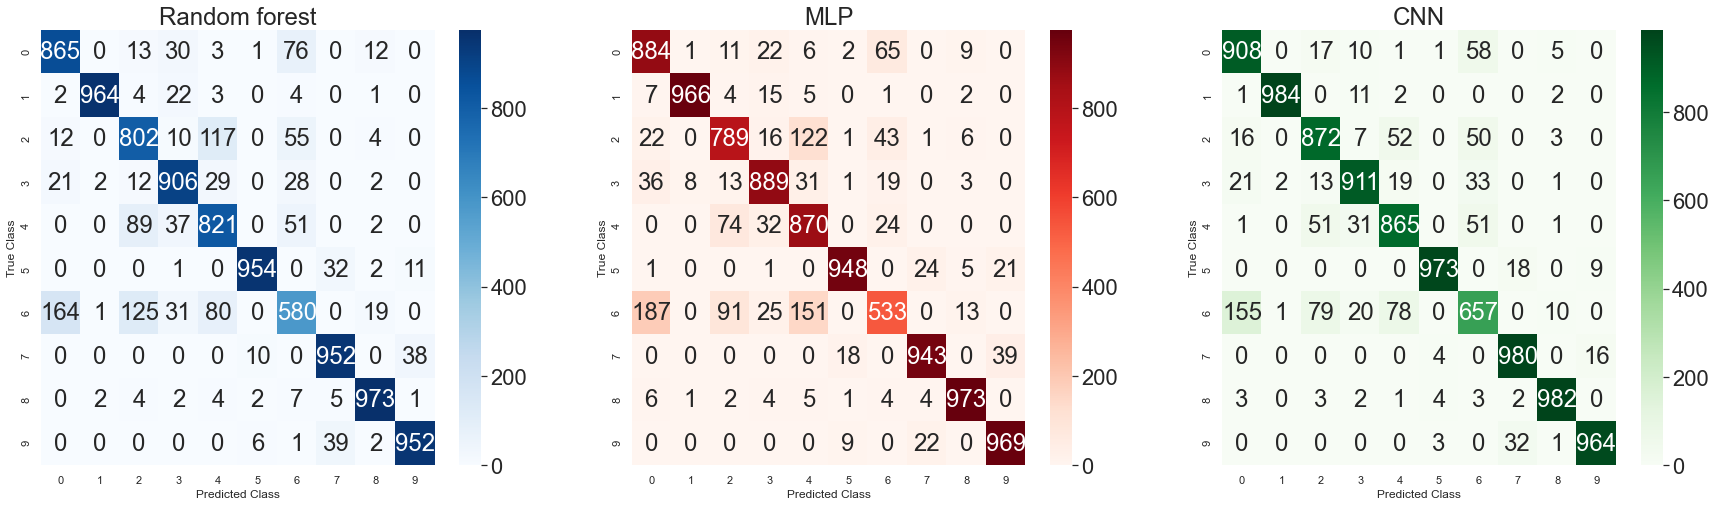

In [545]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (30,8))
sns.set_theme(font_scale = 2)

sns.heatmap(rf_cm, annot=True, cmap='Blues', fmt = 'g', ax = ax1)
ax1.set_title('Random forest')
ax1.set_ylabel('True Class')
ax1.set_xlabel('Predicted Class')

sns.heatmap(mlp_cm, annot=True, cmap='Reds', fmt = 'g', ax = ax2)
ax2.set_title('MLP')
ax2.set_ylabel('True Class')
ax2.set_xlabel('Predicted Class')

sns.heatmap(cnn_cm, annot=True, cmap='Greens', fmt = 'g',ax = ax3)
ax3.set_title('CNN')
ax3.set_ylabel('True Class')
ax3.set_xlabel('Predicted Class')

plt.savefig('cm.jpg')

In [546]:
print('Random forest report by class\n', classification_report(y_test, rf_pred, target_names = class_names, digits = 4))

Random forest report by class
               precision    recall  f1-score   support

 T-shirt/top     0.8130    0.8650    0.8382      1000
     Trouser     0.9948    0.9640    0.9792      1000
    Pullover     0.7645    0.8020    0.7828      1000
       Dress     0.8720    0.9060    0.8887      1000
        Coat     0.7767    0.8210    0.7982      1000
      Sandal     0.9805    0.9540    0.9671      1000
       Shirt     0.7232    0.5800    0.6437      1000
     Sneaker     0.9261    0.9520    0.9389      1000
         Bag     0.9567    0.9730    0.9648      1000
  Ankle boot     0.9501    0.9520    0.9510      1000

    accuracy                         0.8769     10000
   macro avg     0.8758    0.8769    0.8753     10000
weighted avg     0.8758    0.8769    0.8753     10000



In [547]:
print('MLP report by class\n', classification_report(y_test, mlp_pred, target_names = class_names, digits = 4))

MLP report by class
               precision    recall  f1-score   support

 T-shirt/top     0.7734    0.8840    0.8250      1000
     Trouser     0.9898    0.9660    0.9777      1000
    Pullover     0.8018    0.7890    0.7954      1000
       Dress     0.8855    0.8890    0.8872      1000
        Coat     0.7311    0.8700    0.7945      1000
      Sandal     0.9673    0.9480    0.9576      1000
       Shirt     0.7736    0.5330    0.6311      1000
     Sneaker     0.9487    0.9430    0.9458      1000
         Bag     0.9624    0.9730    0.9677      1000
  Ankle boot     0.9417    0.9690    0.9552      1000

    accuracy                         0.8764     10000
   macro avg     0.8775    0.8764    0.8737     10000
weighted avg     0.8775    0.8764    0.8737     10000



In [548]:
print('CNN report by class\n', classification_report(y_test, cnn_pred, target_names = class_names, digits = 4))

CNN report by class
               precision    recall  f1-score   support

 T-shirt/top     0.8217    0.9080    0.8627      1000
     Trouser     0.9970    0.9840    0.9904      1000
    Pullover     0.8425    0.8720    0.8570      1000
       Dress     0.9183    0.9110    0.9147      1000
        Coat     0.8497    0.8650    0.8573      1000
      Sandal     0.9878    0.9730    0.9804      1000
       Shirt     0.7711    0.6570    0.7095      1000
     Sneaker     0.9496    0.9800    0.9646      1000
         Bag     0.9771    0.9820    0.9796      1000
  Ankle boot     0.9747    0.9640    0.9693      1000

    accuracy                         0.9096     10000
   macro avg     0.9090    0.9096    0.9085     10000
weighted avg     0.9090    0.9096    0.9085     10000

